In [34]:
import numpy as np
import torch
import pandas as pd

import matplotlib.pyplot as plt

from collections import namedtuple
import seaborn as sns
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import data_processing as dp
import model
import model_utilities as util
import vocab
import batch_samplers

Impossible to import Faiss library!! Switching to standard nearest neighbors search implementation, this will be significantly slower.



In [3]:
import os

In [4]:
import importlib

In [93]:
importlib.reload(model)
# importlib.reload(main)

<module 'model' from '/data/itasarom/diplom/gan_embeddings/refactoring/model.py'>

In [91]:
from main import global_config, training_params, model_params

In [7]:
os.environ['CUDA_VISIBLE_DEVICES'] = "2"

In [95]:
from launch_utils import find_latest_experiment

In [183]:
TRAINED_MODELS_FOLDER = os.path.join("../", global_config["trained_models"])

In [220]:
model_name = os.path.join("", global_config["model_name"])
model_folder = os.path.join(TRAINED_MODELS_FOLDER, model_name)
latest_folder = find_latest_experiment(model_folder) if os.path.exists(model_folder) else None
model_params["n_topics"] = 26

In [221]:
model_folder

'../trained_models_result/debug'

In [8]:
    vocab1, all_labels, sents1, labels1 = dp.load_problem(lang=model_params["src_lang"], max_sent_length=model_params["max_sent_length"])
    vocab2, all_labels, sents2, labels2 = dp.load_problem(lang=model_params["tgt_lang"], max_sent_length=model_params["max_sent_length"])
    vocab1.embeddings = dp.normalize_embeddings(vocab1.embeddings)
    vocab2.embeddings = dp.normalize_embeddings(vocab2.embeddings)

    model_params["n_topics"] = len(all_labels)

    sent_sampler_1 = batch_samplers.BatchSamplerRegularizer(sents=sents1, labels=labels1, vocab=vocab1, all_labels=all_labels, max_sent_length=None, seed=model_params["sentence_seed"])
    sent_sampler_2 = batch_samplers.BatchSamplerRegularizer(sents=sents2, labels=labels2, vocab=vocab2, all_labels=all_labels, max_sent_length=None, seed=model_params["sentence_seed"])
    embed_sampler_1 = batch_samplers.BatchSamplerDiscriminator(vocab1)
    embed_sampler_2 = batch_samplers.BatchSamplerDiscriminator(vocab2)

In [222]:
cls = model.GAN(model_params)
if global_config["use_cuda"]:
    cls = cls.cuda()
trainer = util.Trainer(cls, global_config)
trainer.restore(os.path.join(latest_folder, "model_state.tc"))

In [203]:
from collections import defaultdict
def extract_translation_validation(validation_metrics):
    metrics = validation_metrics["translation"]
    result = defaultdict(lambda:defaultdict(list))
    for i, metric in enumerate(metrics):
        for k1, v1 in metric.items():
            for k2, v2 in v1.items():
                if k2 == 'n_iter':
                    continue
                result[k1][k2].append(v2)
    
    return result
        
def plot_train_metrics(latest_folder, train_metrics, validation_metrics):
    plt.figure(figsize=(15, 10))
    plt.title(latest_folder + " classifier loss")
    plt.plot(train_metrics["classifier_losses"], color='green', label="train")
    plt.plot(validation_metrics["validation_iterations"], validation_metrics["sents1_valid_loss"], color='orange', label='sents_1')
    plt.plot(validation_metrics["validation_iterations"], validation_metrics["sents2_valid_loss"], color='blue', label='sents_2')
    plt.plot(validation_metrics["validation_iterations"], validation_metrics["sents1_train_loss"], color='gray', label='sents_1_train')
    plt.plot(validation_metrics["validation_iterations"], validation_metrics["sents2_train_loss"], color='brown', label='sents_2_train')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(15, 10))
    plt.title(latest_folder + " classifier accuracy")
#     plt.plot(train_metrics["classifier_"], color='green', label="train")
    plt.plot(validation_metrics["validation_iterations"], validation_metrics["sents1_valid_accuracy"], color='orange', label='sents_1')
    plt.plot(validation_metrics["validation_iterations"], validation_metrics["sents2_valid_accuracy"], color='blue', label='sents_2')
    plt.plot(validation_metrics["validation_iterations"], validation_metrics["sents1_train_accuracy"], color='gray', label='sents_1_train')
    plt.plot(validation_metrics["validation_iterations"], validation_metrics["sents2_train_accuracy"], color='brown', label='sents_2_train')
    plt.legend()
    plt.show()


    plt.figure(figsize=(15, 10))
    plt.title(latest_folder + " discriminator loss")
    plt.plot(train_metrics["discriminator_losses"], color='green', label='train')
    plt.plot(validation_metrics["validation_iterations"], validation_metrics["validation_discriminator_losses"], color='red', label='valid')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(15, 10))
    plt.title(latest_folder + " transformation loss")
    plt.plot(train_metrics["transformation_losses"])
    plt.show()
    
    muse_scores = extract_translation_validation(validation_metrics)
    
    iterations = validation_metrics["validation_iterations"]
    
    for test_set, results in muse_scores.items():
        plt.figure(figsize=(15, 10))
        plt.title(latest_folder + " " + test_set)
        for metric_name, values in results.items():
            plt.ylim(0.0, 100.0)
            plt.plot(iterations, values, label=metric_name)
            print(test_set, metric_name, values[-1], max(values), values.index(max(values)))
        plt.legend()
        plt.show()


In [177]:
import pickle

In [227]:
with open(os.path.join(latest_folder, "validation_metrics.pkl"), "rb") as f:
            trainer.validation_metrics = pickle.load(f)
        
with open(os.path.join(latest_folder, "train_metrics.pkl"), "rb") as f:
            trainer.train_metrics = pickle.load(f)

In [195]:
# trainer_without_cls = trainer

In [188]:
# trainer_with_cls = trainer

In [189]:
# extract_translation_validation(trainer.validation_metrics)

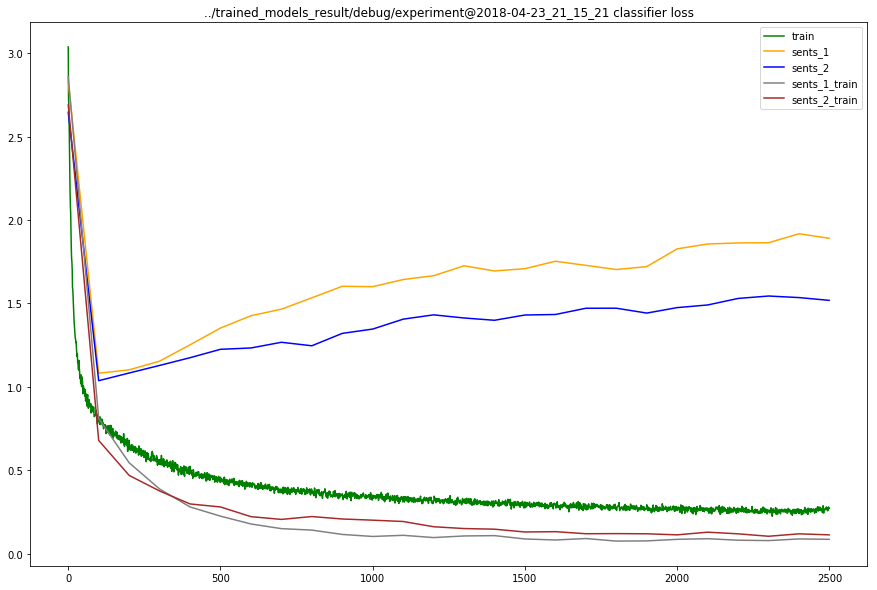

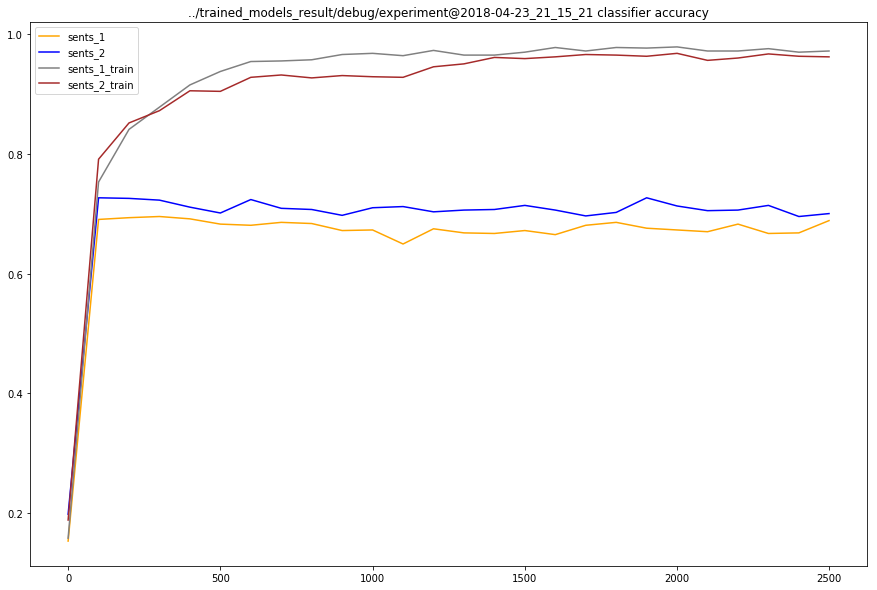

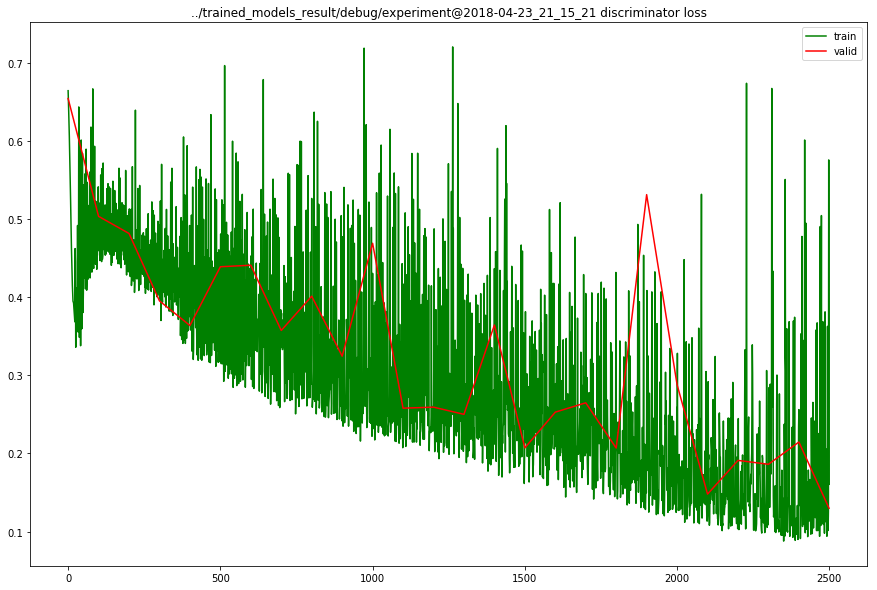

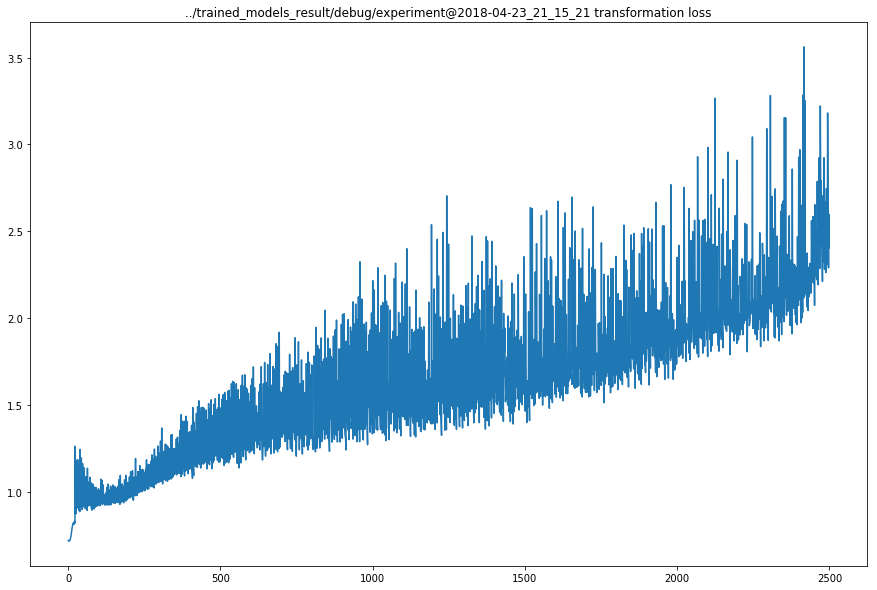

valid_tgt_src precision_at_5-nn 74.73790322580646 78.52822580645162 23
valid_tgt_src precision_at_10-csls_knn_10 83.18548387096774 85.16129032258064 23
valid_tgt_src precision_at_10-nn 79.15322580645162 82.1774193548387 22
valid_tgt_src precision_at_5-csls_knn_10 79.65725806451613 81.89516129032258 23
valid_tgt_src precision_at_1-csls_knn_10 65.40322580645162 69.6774193548387 22
valid_tgt_src precision_at_1-nn 59.05241935483871 64.03225806451613 22


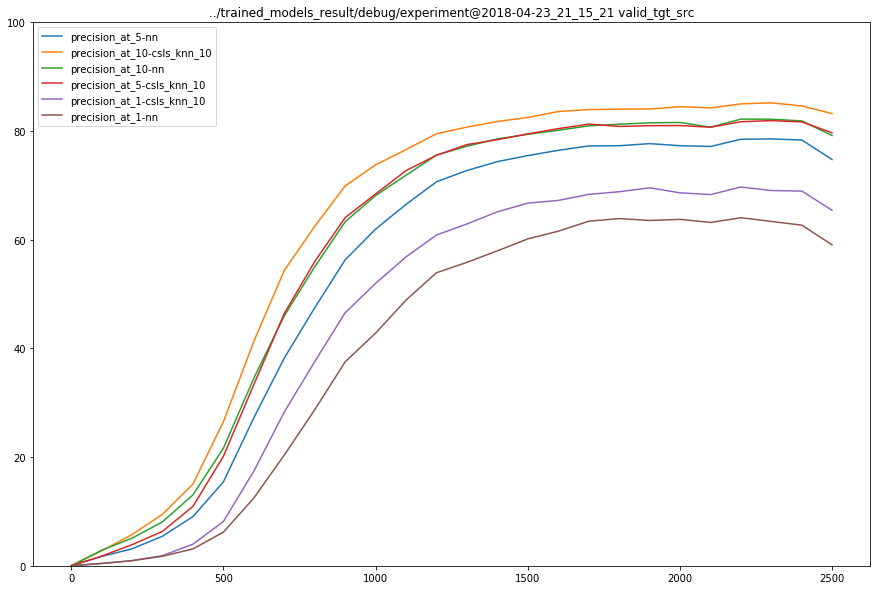

valid_src_tgt precision_at_5-nn 81.37274751974084 84.3895525410002 24
valid_src_tgt precision_at_10-csls_knn_10 88.62117837618952 90.76736181413241 24
valid_src_tgt precision_at_10-nn 85.52338530066815 88.37821421340352 23
valid_src_tgt precision_at_5-csls_knn_10 84.47054059526221 87.46709860295606 24
valid_src_tgt precision_at_1-csls_knn_10 69.95343186879936 73.67888236485118 24
valid_src_tgt precision_at_1-nn 65.49908888438955 69.69022069244787 24


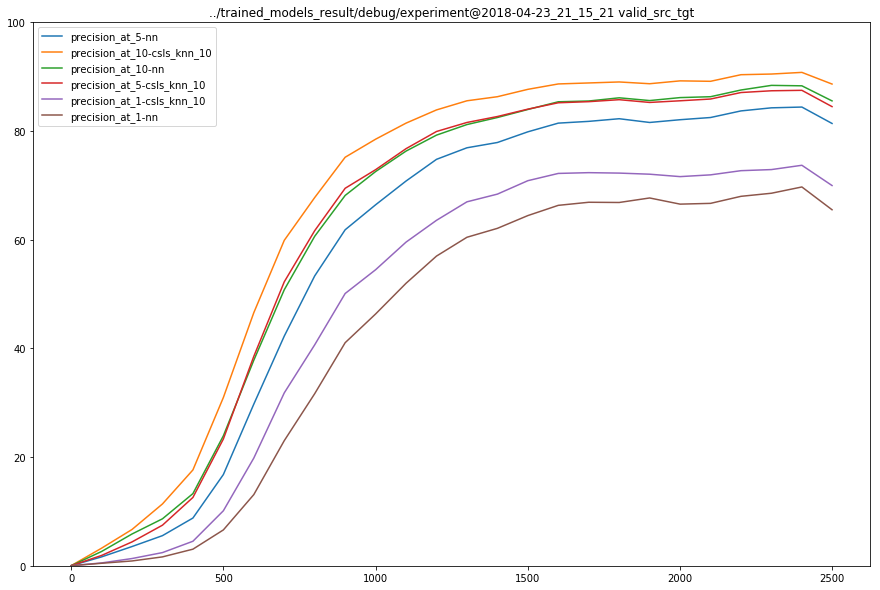

test_tgt_src precision_at_5-nn 74.35020519835841 79.75376196990423 24
test_tgt_src precision_at_10-csls_knn_10 84.33652530779754 87.27770177838578 23
test_tgt_src precision_at_10-nn 80.30095759233926 84.06292749658003 23
test_tgt_src precision_at_5-csls_knn_10 80.71135430916553 83.72093023255815 24
test_tgt_src precision_at_1-csls_knn_10 64.77428180574556 69.35704514363886 19
test_tgt_src precision_at_1-nn 57.3187414500684 63.132694938440494 23


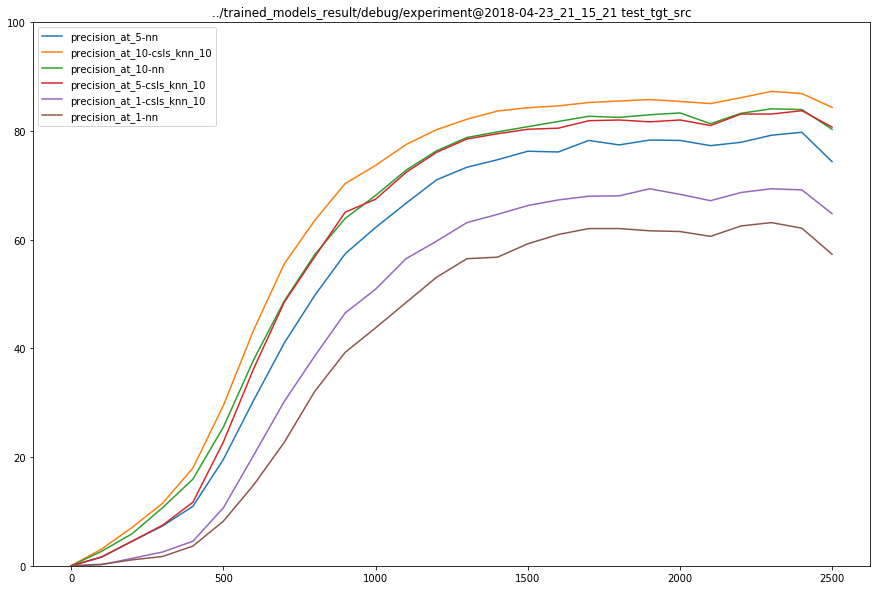

test_src_tgt precision_at_5-nn 79.34111187371312 82.15511324639671 24
test_src_tgt precision_at_10-csls_knn_10 86.75360329444062 89.36170212765957 24
test_src_tgt precision_at_10-nn 83.66506520247083 86.27316403568977 24
test_src_tgt precision_at_5-csls_knn_10 82.91008922443378 85.99862731640357 24
test_src_tgt precision_at_1-csls_knn_10 68.84008236101579 71.79135209334248 23
test_src_tgt precision_at_1-nn 64.37886067261496 67.46739876458476 23


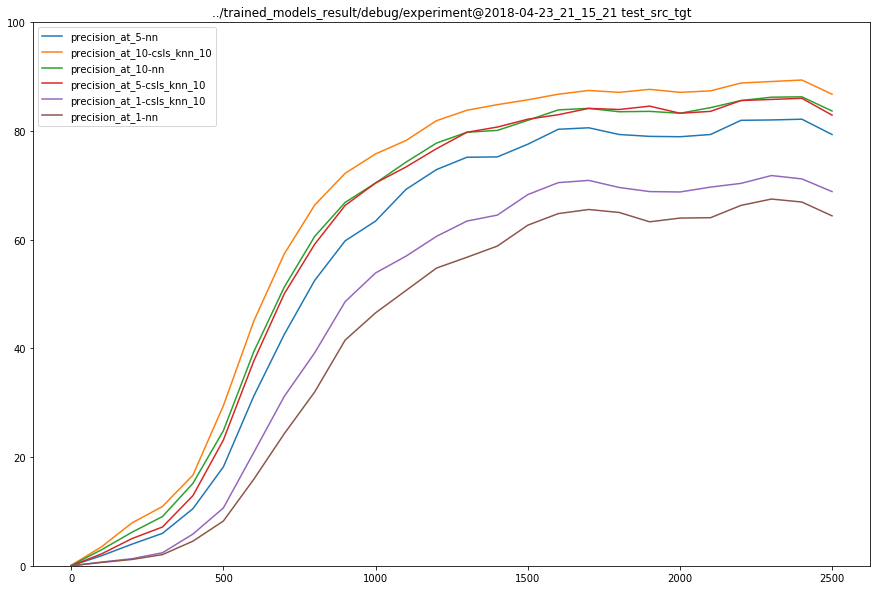

In [215]:
plot_train_metrics(latest_folder, trainer_with_cls.train_metrics, trainer_with_cls.validation_metrics)

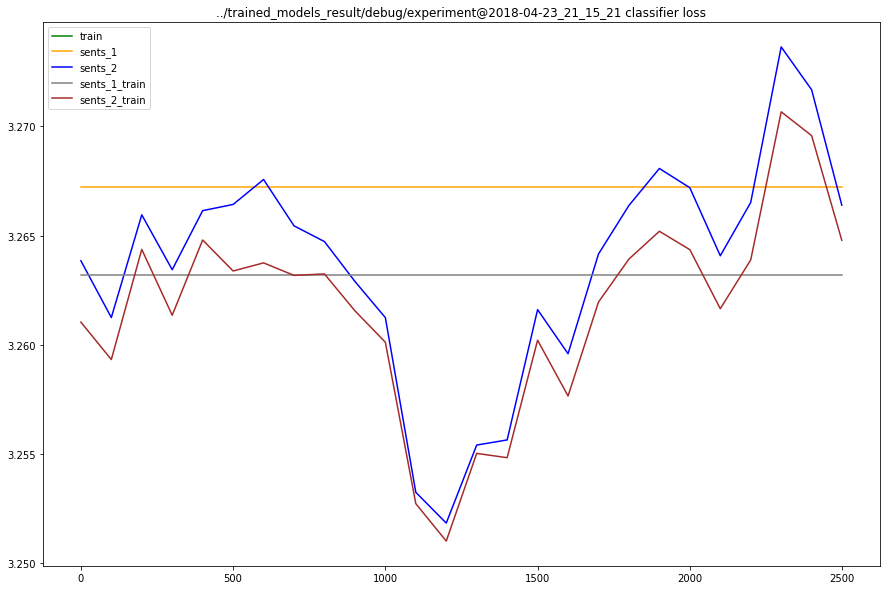

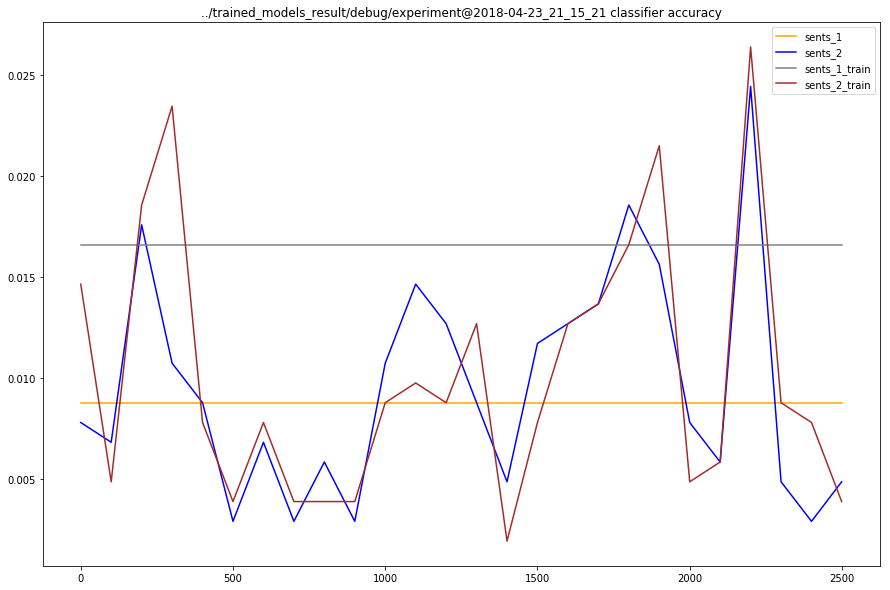

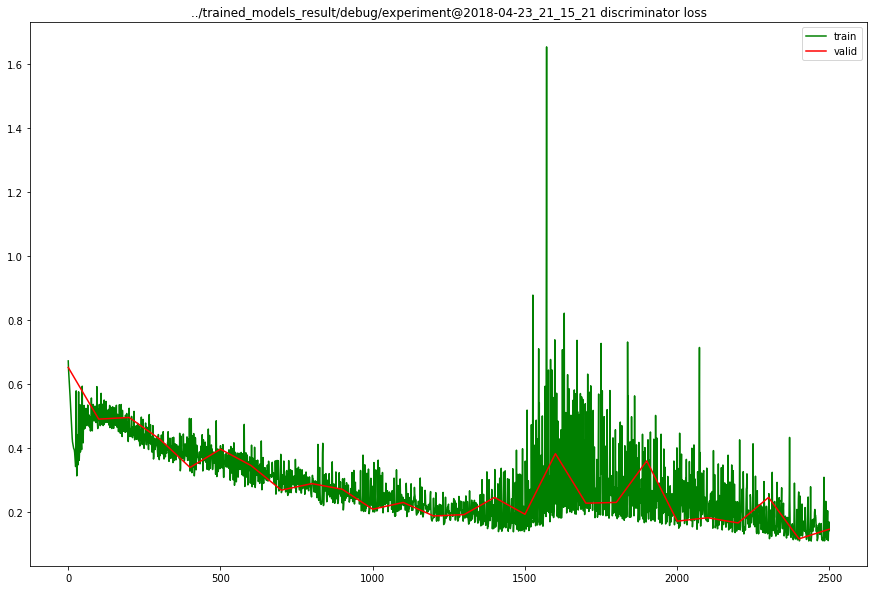

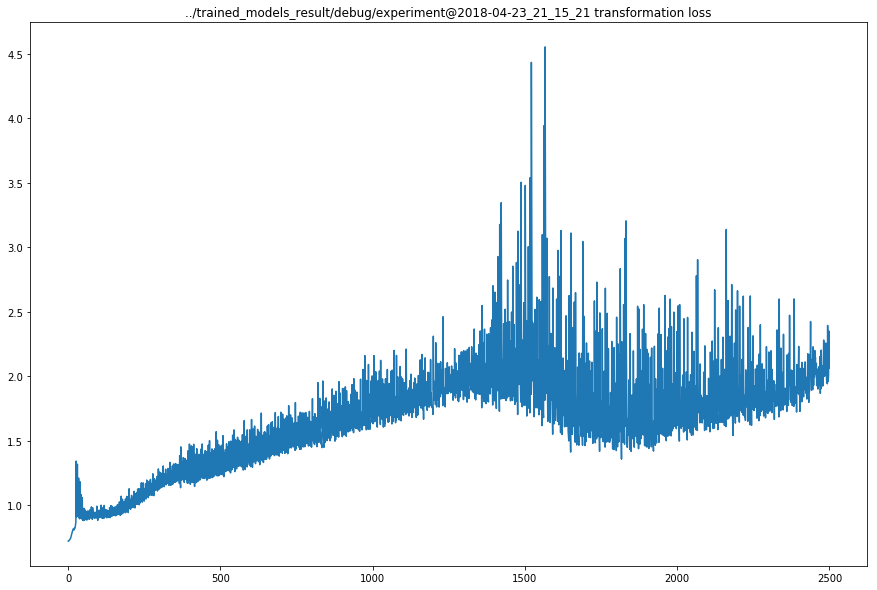

valid_tgt_src precision_at_5-nn 78.91129032258064 79.35483870967742 23
valid_tgt_src precision_at_10-csls_knn_10 85.96774193548387 85.96774193548387 25
valid_tgt_src precision_at_10-nn 82.5 83.26612903225806 24
valid_tgt_src precision_at_5-csls_knn_10 82.64112903225806 82.7217741935484 24
valid_tgt_src precision_at_1-csls_knn_10 70.26209677419355 70.26209677419355 25
valid_tgt_src precision_at_1-nn 65.44354838709677 65.60483870967741 24


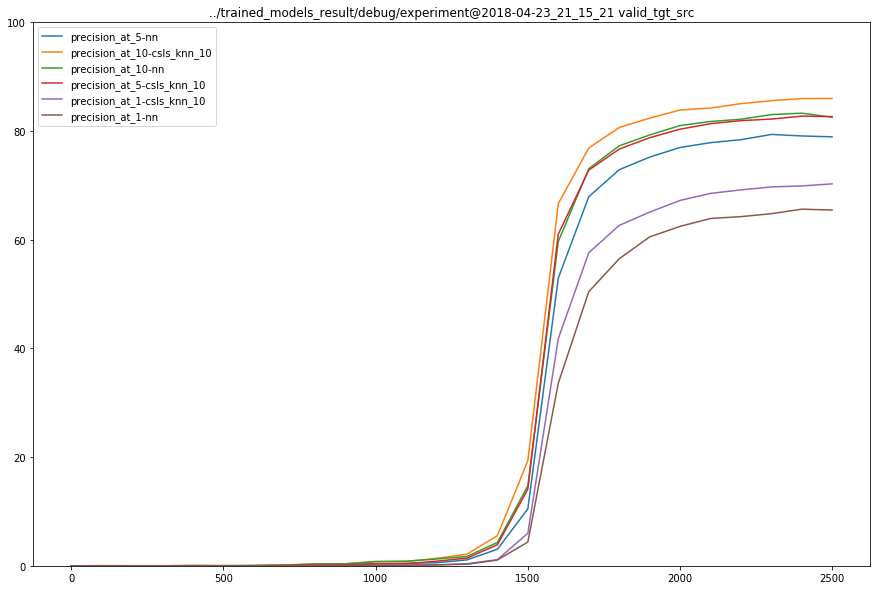

valid_src_tgt precision_at_5-nn 85.28042113788217 85.28042113788217 25
valid_src_tgt precision_at_10-csls_knn_10 90.9698319497874 91.0305729904839 24
valid_src_tgt precision_at_10-nn 88.70216643045151 88.70216643045151 25
valid_src_tgt precision_at_5-csls_knn_10 87.89228588783155 87.89228588783155 25
valid_src_tgt precision_at_1-csls_knn_10 75.3188904636566 75.3188904636566 25
valid_src_tgt precision_at_1-nn 70.56084227576433 70.56084227576433 25


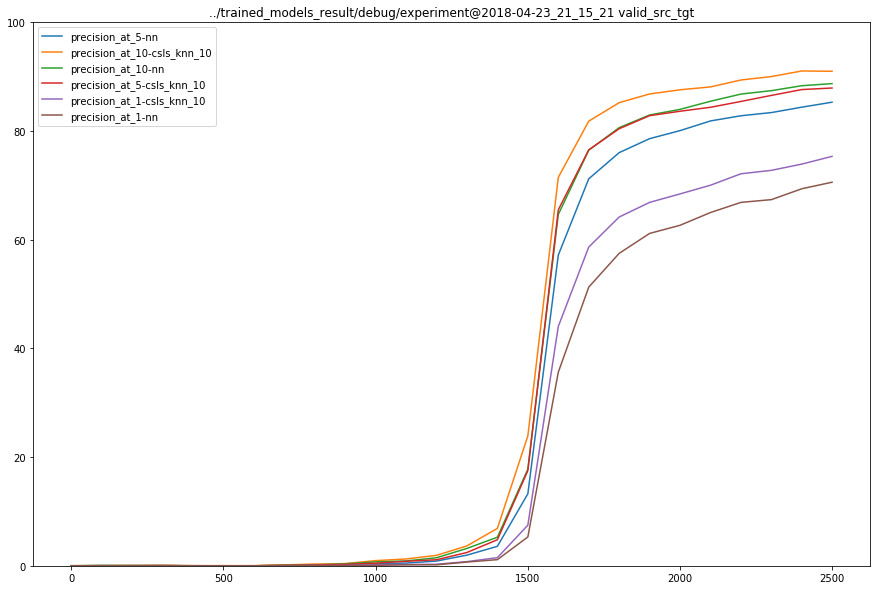

test_tgt_src precision_at_5-nn 80.02735978112176 81.25854993160054 24
test_tgt_src precision_at_10-csls_knn_10 87.20930232558139 87.75649794801642 24
test_tgt_src precision_at_10-nn 84.95212038303693 84.95212038303693 25
test_tgt_src precision_at_5-csls_knn_10 84.61012311901504 84.61012311901504 25
test_tgt_src precision_at_1-csls_knn_10 70.93023255813954 70.93023255813954 25
test_tgt_src precision_at_1-nn 64.77428180574556 64.84268125854993 24


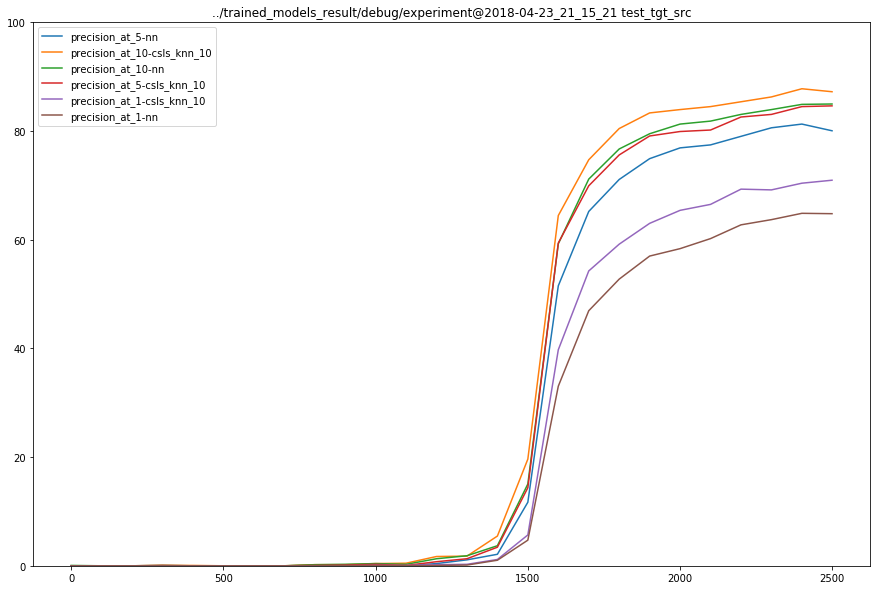

test_src_tgt precision_at_5-nn 84.00823610157858 84.00823610157858 25
test_src_tgt precision_at_10-csls_knn_10 89.84214138641043 89.84214138641043 25
test_src_tgt precision_at_10-nn 87.78311599176389 87.78311599176389 25
test_src_tgt precision_at_5-csls_knn_10 86.20452985586822 86.27316403568977 24
test_src_tgt precision_at_1-csls_knn_10 74.19354838709677 74.19354838709677 25
test_src_tgt precision_at_1-nn 69.9382292381606 69.9382292381606 25


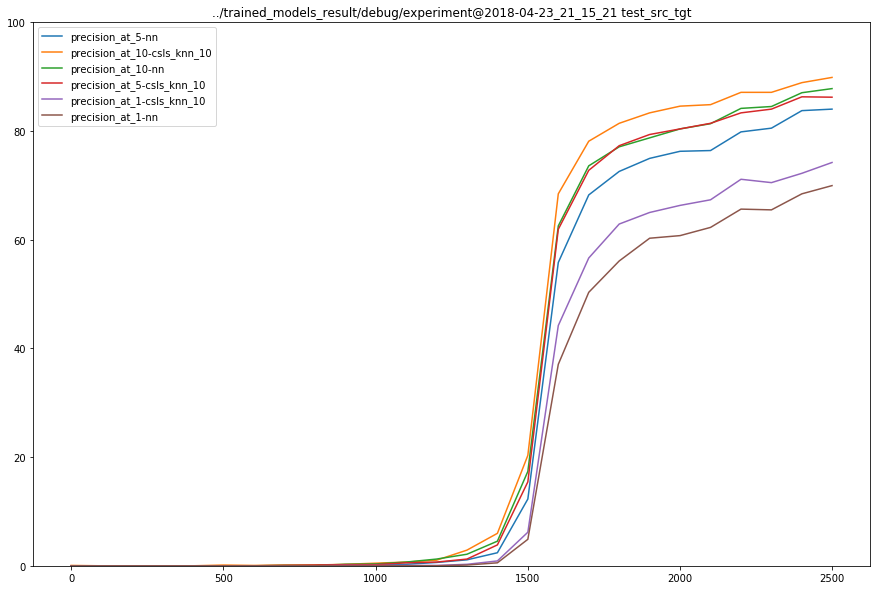

In [206]:
plot_train_metrics(latest_folder, trainer_without_cls.train_metrics, trainer_without_cls.validation_metrics)

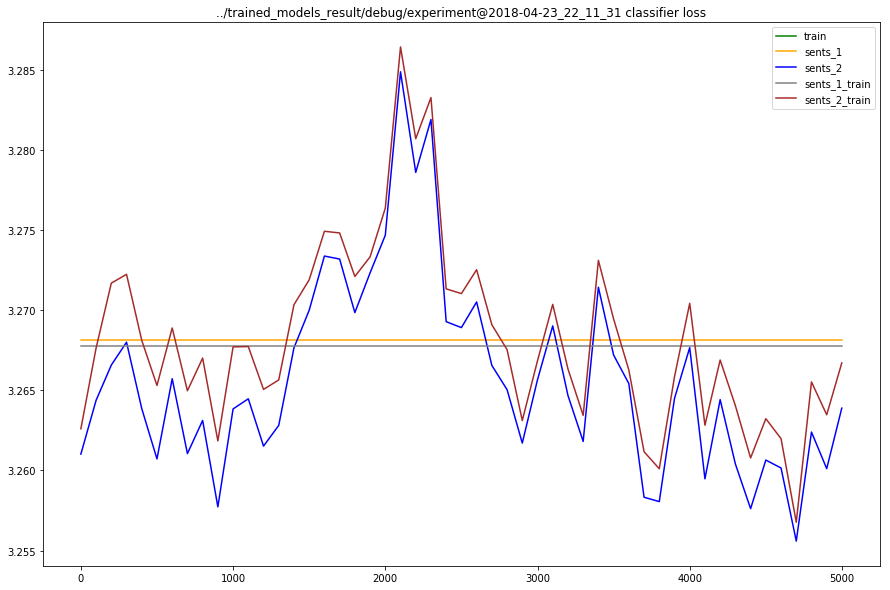

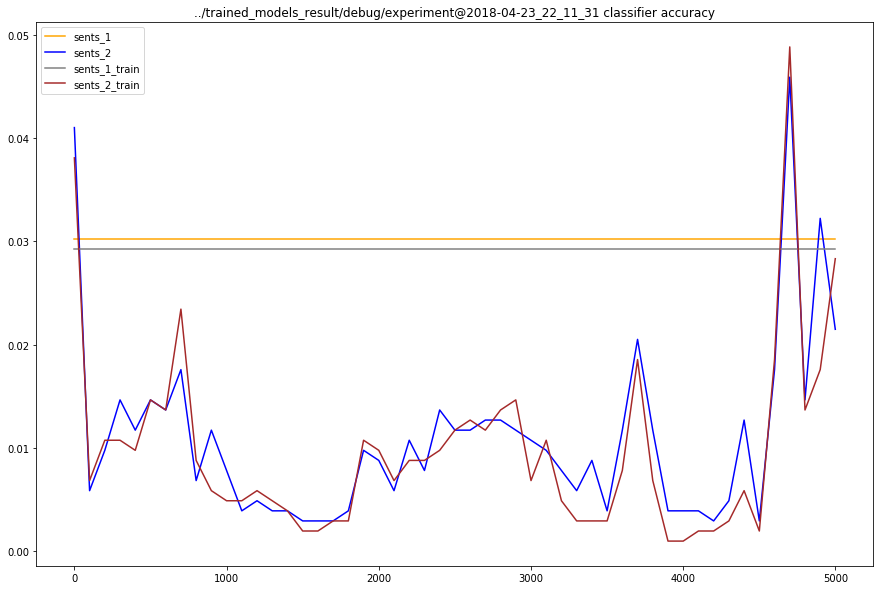

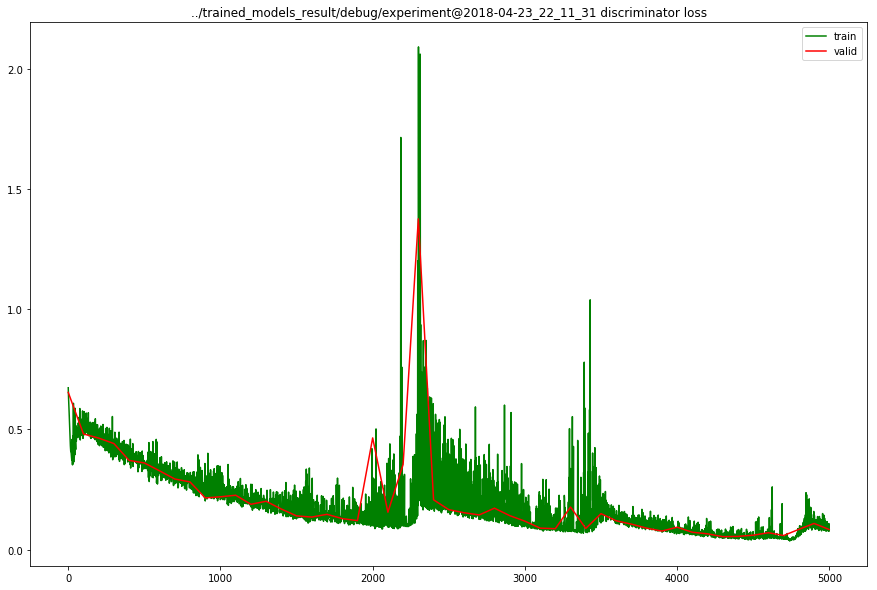

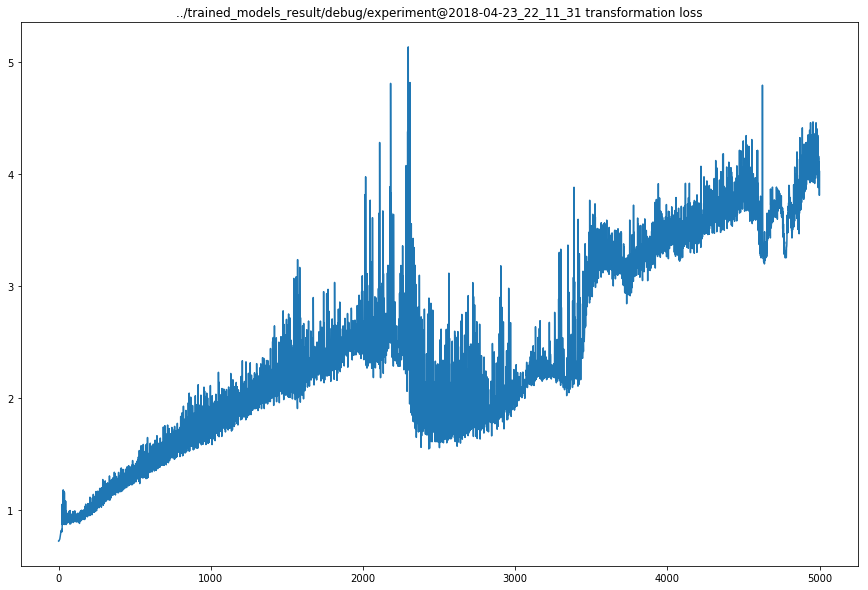

valid_tgt_src precision_at_5-nn 0.24193548387096775 79.73790322580645 33
valid_tgt_src precision_at_10-csls_knn_10 0.4435483870967742 85.50403225806451 34
valid_tgt_src precision_at_10-nn 0.4233870967741936 83.00403225806451 33
valid_tgt_src precision_at_5-csls_knn_10 0.1814516129032258 82.35887096774194 33
valid_tgt_src precision_at_1-csls_knn_10 0.04032258064516129 70.4032258064516 28
valid_tgt_src precision_at_1-nn 0.08064516129032258 65.7258064516129 33


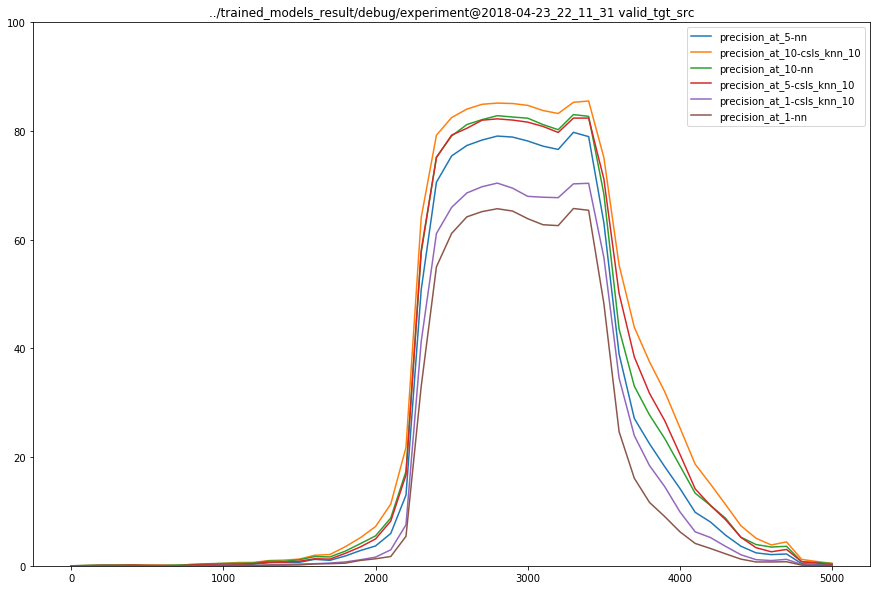

valid_src_tgt precision_at_5-nn 0.3239522170479854 85.09819801579268 30
valid_src_tgt precision_at_10-csls_knn_10 0.7896335290544645 90.32192751569144 29
valid_src_tgt precision_at_10-nn 0.8098805426199636 88.49969629479652 30
valid_src_tgt precision_at_5-csls_knn_10 0.4251872848754809 87.38611054869406 30
valid_src_tgt precision_at_1-csls_knn_10 0.08098805426199635 74.97469123304312 33
valid_src_tgt precision_at_1-nn 0.10123506782749545 70.03441992306135 34


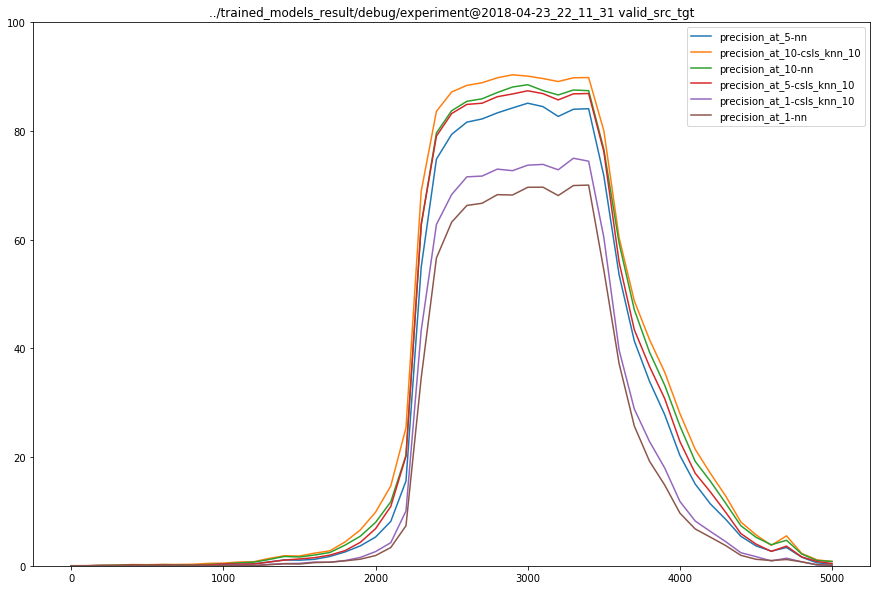

test_tgt_src precision_at_5-nn 0.2051983584131327 80.36935704514364 33
test_tgt_src precision_at_10-csls_knn_10 0.3419972640218878 87.27770177838578 33
test_tgt_src precision_at_10-nn 0.27359781121751026 84.33652530779754 34
test_tgt_src precision_at_5-csls_knn_10 0.2051983584131327 83.515731874145 33
test_tgt_src precision_at_1-csls_knn_10 0.06839945280437756 71.20383036935705 33
test_tgt_src precision_at_1-nn 0.0 64.50068399452805 29


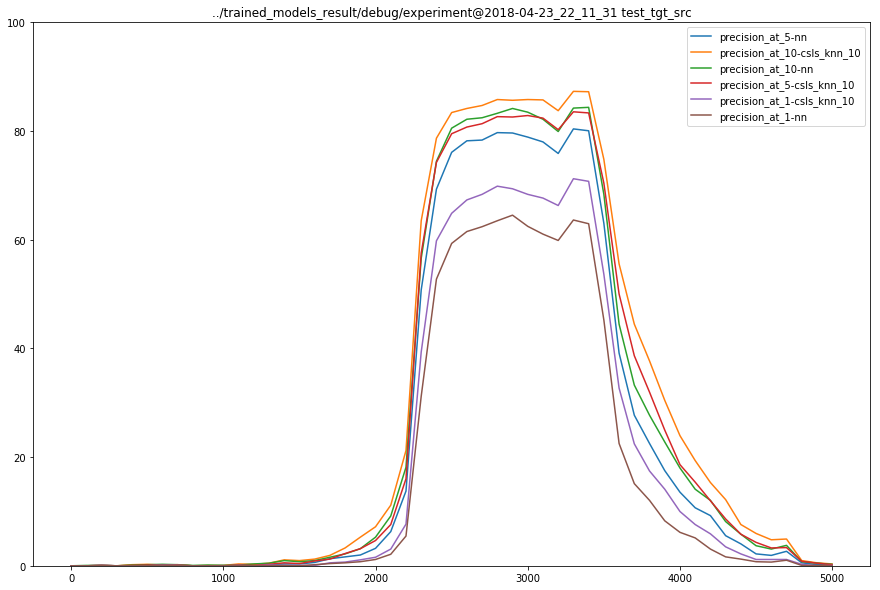

test_src_tgt precision_at_5-nn 0.4804392587508579 82.63555250514756 30
test_src_tgt precision_at_10-csls_knn_10 0.4804392587508579 88.46945778997942 30
test_src_tgt precision_at_10-nn 0.5490734385724091 86.47906657515443 30
test_src_tgt precision_at_5-csls_knn_10 0.41180507892930684 84.90048043925876 34
test_src_tgt precision_at_1-csls_knn_10 0.20590253946465342 72.27179135209335 34
test_src_tgt precision_at_1-nn 0.0 67.33013040494166 34


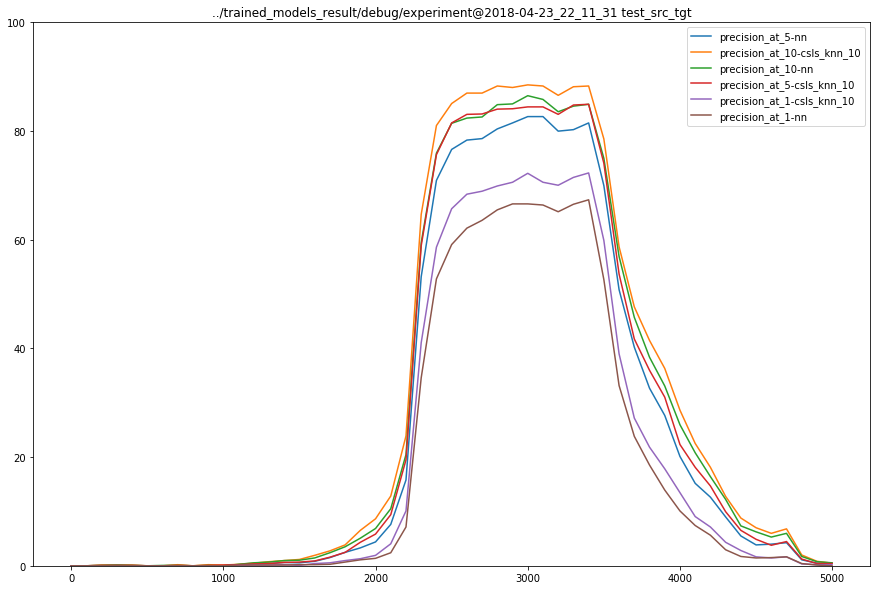

In [228]:
plot_train_metrics(latest_folder, trainer.train_metrics, trainer.validation_metrics)

In [218]:
def compare_validations(val_1, val_2, metric_names):
    scores_1 = extract_translation_validation(val_1)
    iterations_1 = val_1["validation_iterations"]
    scores_2 = extract_translation_validation(val_2)
    iterations_2 = val_2["validation_iterations"]
    
    assert set(scores_1.keys()) == set(scores_2.keys())
    
    for test_set in scores_1.keys():
        plt.figure(figsize=(15, 10))
        plt.title(latest_folder + " " + test_set)
        for metric_name in scores_1[test_set].keys():
            if metric_name not in metric_names:
                continue
            plt.ylim(0.0, 100.0)
            plt.plot(iterations_1, scores_1[test_set][metric_name], label="1 " + metric_name)
            plt.plot(iterations_2, scores_2[test_set][metric_name], label="2 " + metric_name)
#             print(test_set, metric_name, values[-1], max(values), values.index(max(values)))
        plt.legend()
        plt.show()

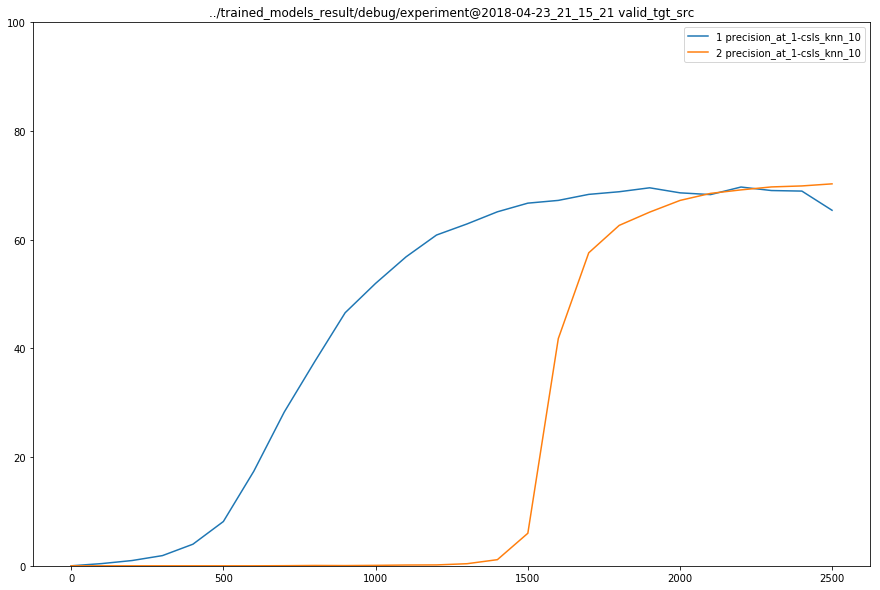

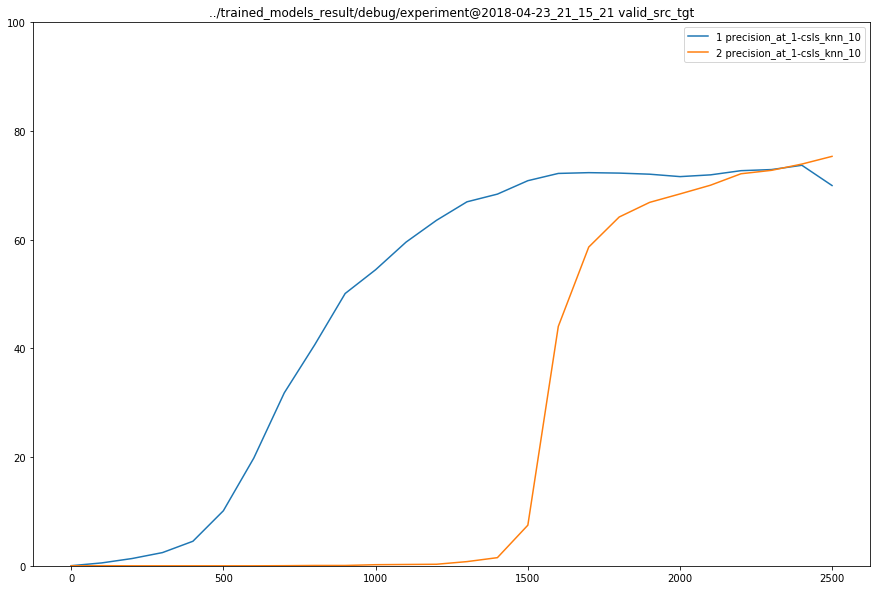

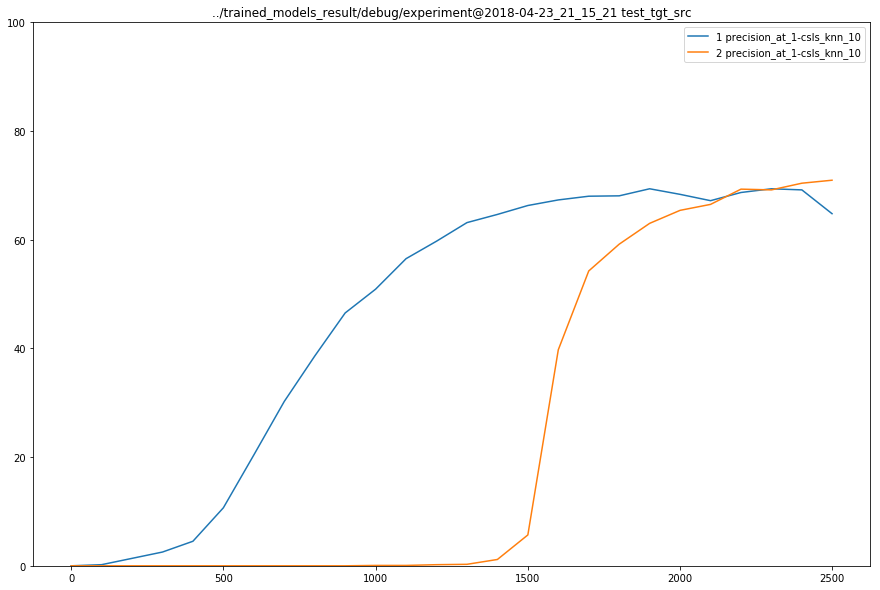

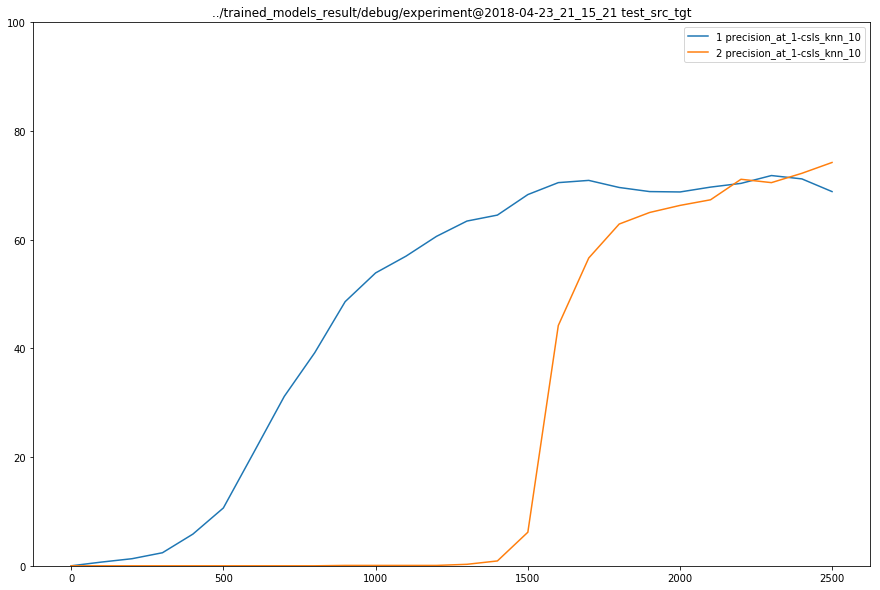

In [219]:
compare_validations(trainer_with_cls.validation_metrics, trainer_without_cls.validation_metrics, ["precision_at_1-csls_knn_10"])

In [17]:
import sklearn
from sklearn.metrics import log_loss, accuracy_score

In [18]:
def build_confusion_matrix(predicted_probs, true_y):
    n_labels = predicted_probs.shape[1]
#     assert true_y.shape == predicted_probs.shape
    result = np.zeros(shape=(n_labels, n_labels))
    
    pred = predicted_probs.argmax(axis=1)
#     true = true_y.argmax(axis=1)
    true = true_y
    
    for pred_cls in range(n_labels):
        for true_cls in range(n_labels):
            result[true_cls, pred_cls] = np.count_nonzero(true[pred == pred_cls] == true_cls)
#     norm = result.sum(axis=1)
#     norm = np.maximum(norm, 1)
#     result /= norm[:, None]
    return result


In [19]:
def get_probs(transformation, model, embeddings, batch_size, use_cuda):
    result = []
#     embed_sum = 0.0
#     squares_sum = 0.0
    embeds = []
    for position in range(0, len(embeddings), batch_size):
        x = embeddings[position:position + batch_size]
        x = torch.autograd.Variable(torch.from_numpy(x)).float()
        if use_cuda:
            x = x.cuda()
        
        x = transformation(x)
        _, probs = model.discriminator.forward(x)
        probs = probs.data.cpu().numpy()
        result.append(probs)
        
        x = x.cpu().data.numpy()
#         embed_sum += x
        embeds.append(x)
    
    result = np.vstack(result)
    z = 1 - result
    result = np.hstack([z, result])
    return result, np.vstack(embeds)

In [20]:
def build_confusion_matrix(predicted_probs, true_y):
    n_labels = predicted_probs.shape[1]
#     assert true_y.shape == predicted_probs.shape
    result = np.zeros(shape=(n_labels, n_labels))
    
    pred = predicted_probs.argmax(axis=1)
#     true = true_y.argmax(axis=1)
    true = true_y
    
    for pred_cls in range(n_labels):
        for true_cls in range(n_labels):
            result[true_cls, pred_cls] = np.count_nonzero(true[pred == pred_cls] == true_cls)
#     norm = result.sum(axis=1)
#     norm = np.maximum(norm, 1)
#     result /= norm[:, None]
    return result


In [21]:
def validate(model, embeddings_1, embeddings_2, batch_size, use_cuda):
    probs_1, t1 = get_probs(model.transform1, model, embeddings_1, batch_size, use_cuda)
    probs_2, t2 = get_probs(model.transform2, model, embeddings_2, batch_size, use_cuda)
    probs = np.vstack([probs_1, probs_2])
    
    pred_1 = probs_1.argmax(axis=1).reshape(-1, 1)
    pred_2 = probs_2.argmax(axis=1).reshape(-1, 1)    
    pred = np.vstack([pred_1, pred_2])
    
    y_true = np.concatenate([np.zeros((len(pred_1),)), np.ones((len(pred_2)))])
    
    
    acc = accuracy_score(y_pred=pred, y_true=y_true)
    loss = log_loss(y_pred=probs, y_true=y_true)
    cm = build_confusion_matrix(probs, y_true)
    
    plt.hist(probs[y_true == 1, 1], bins=100, label="1", color='orange')
    plt.hist(probs[y_true == 0, 1], bins=100, label="0", color='blue')
    
    plt.legend()
    plt.show()
    

    plt.hist(probs[y_true == 0, 1], bins=100, label="0", color='blue')
    plt.hist(probs[y_true == 1, 1], bins=100, label="1", color='orange')
    
    plt.legend()
    plt.show()
    
    t = np.vstack([t1, t2])
    
    return acc, loss, cm, probs, y_true , t
    

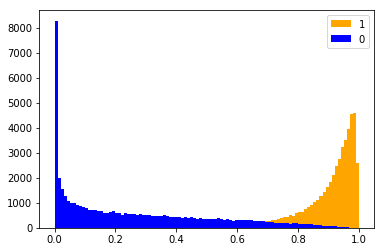

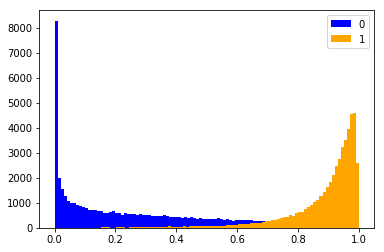

Accuracy  0.8876722465550689
Loss  0.2628440091029237
Confusion matrix
 [[40007.  9994.]
 [ 1239. 48762.]]
Min component variance 0.8084484934806824, median component variance 0.9007863998413086, mean component variance 0.8998941779136658, max c v 0.9669576287269592
Total length  100002


In [22]:
cls.eval()
result = validate(cls, vocab1.embeddings, vocab2.embeddings, 200, use_cuda=True)
print("Accuracy ", result[0])
print("Loss ", result[1])
print("Confusion matrix\n", result[2])
vars = result[-1].var(axis=0)
print("Min component variance {}, median component variance {}, mean component variance {}, max c v {}".format(
        min(vars), np.median(vars), np.mean(vars), max(vars)
    ))
print("Total length ", len(result[-1]))

In [23]:
# cls.discriminator.actual_model.zero_grad()

In [24]:
embeds = result[-1]

In [25]:
# embeds = normalize_embeddings(embeds)

In [26]:
embeds1 = embeds[:len(vocab1.embeddings)]
embeds2 = embeds[len(vocab1.embeddings):]

/data/itasarom/torch/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


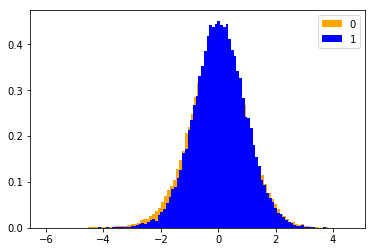

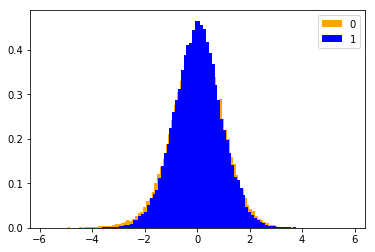

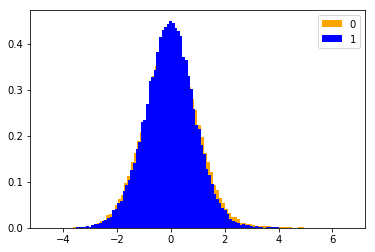

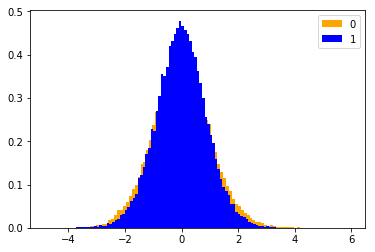

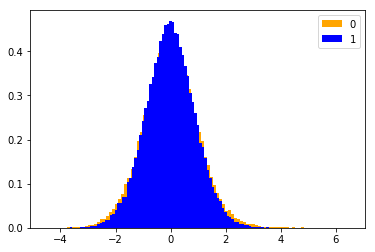

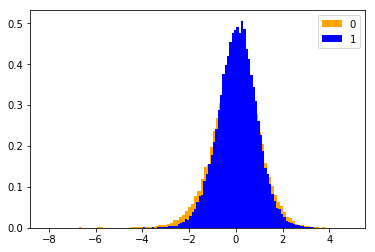

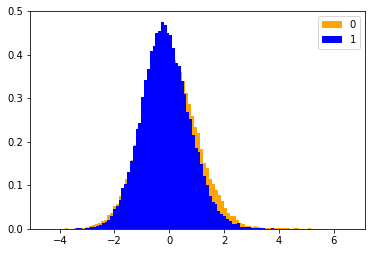

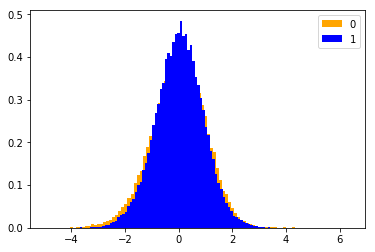

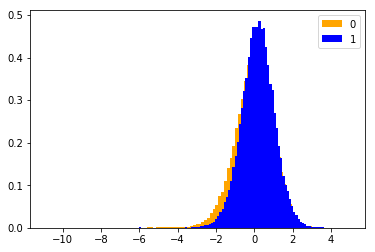

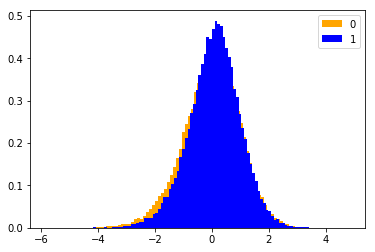

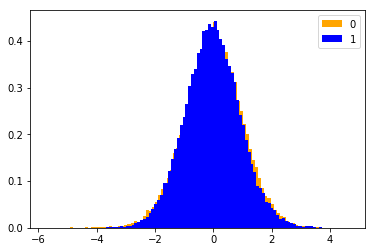

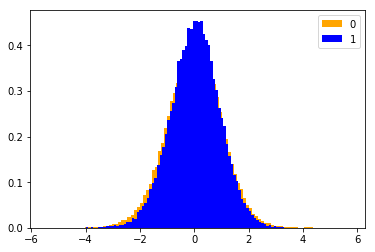

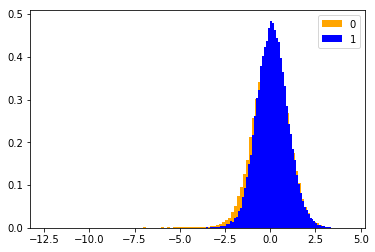

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [27]:
for i in range(100):
    plt.hist(embeds1[:, i], color='orange', bins=100, label='0', normed=True)
    plt.hist(embeds2[:, i], color='blue', bins=100, label='1', normed=True)
    plt.legend()
    plt.show()

In [28]:
import evaluation

In [29]:
def describe(sent_sampler, model, transformation):
    model.eval()
    x, mask, y = sent_sampler.get_test()
#     x, mask, y = sent_sampler.get_train_valid()
    true_y = np.zeros(shape=(len(y), len(sent_sampler.unique_labels)), dtype=np.int32)
    for idx, current_y in enumerate(y):
        true_y[idx, current_y] = 1
    
    x, mask, y = model.prepare_data_for_classifier(x, mask, y, transformation)
    
    if model.is_cuda:
        x = x.cuda()
        y = y.cuda()
        mask = mask.cuda()
    

    
    loss = model.classifier.get_loss(x, mask, y).data.cpu().numpy()
    probs = model.classifier(x, mask)[1].data.cpu().numpy()
    
    pred = np.argmax(probs, axis=1)
    
    acc = evaluation.accuracy(predicted_probs=probs, true_y=true_y)
    prec = {}
    rec = {}
    for cls in range(true_y.shape[1]):
        prec[cls] = evaluation.precision_by_class(probs, true_y, cls)
        rec[cls] = evaluation.recall_by_class(probs, true_y, cls)
    
    return acc, prec, rec, evaluation.build_confusion_matrix(probs, true_y)

    

In [30]:
acc, prec, rec, confusion_matrix = describe(sent_sampler_1, cls, cls.transform1)

In [31]:
print(acc, len(sent_sampler_1.sents))

(704, 1024, 0.6875) 17860


In [32]:
print(acc, len(sent_sampler_1.sents))

(704, 1024, 0.6875) 17860


In [35]:
evaluation.plot_confusion_matrix(confusion_matrix)

NameError: name 'plt' is not defined

In [142]:
acc, prec, rec, confusion_matrix = describe(sent_sampler_2, cls, cls.transform2)

In [143]:
print(acc, len(sent_sampler_2.sents))

(716, 1024, 0.69921875) 18467


In [144]:
print(acc, len(sent_sampler_2.sents))

(716, 1024, 0.69921875) 18467


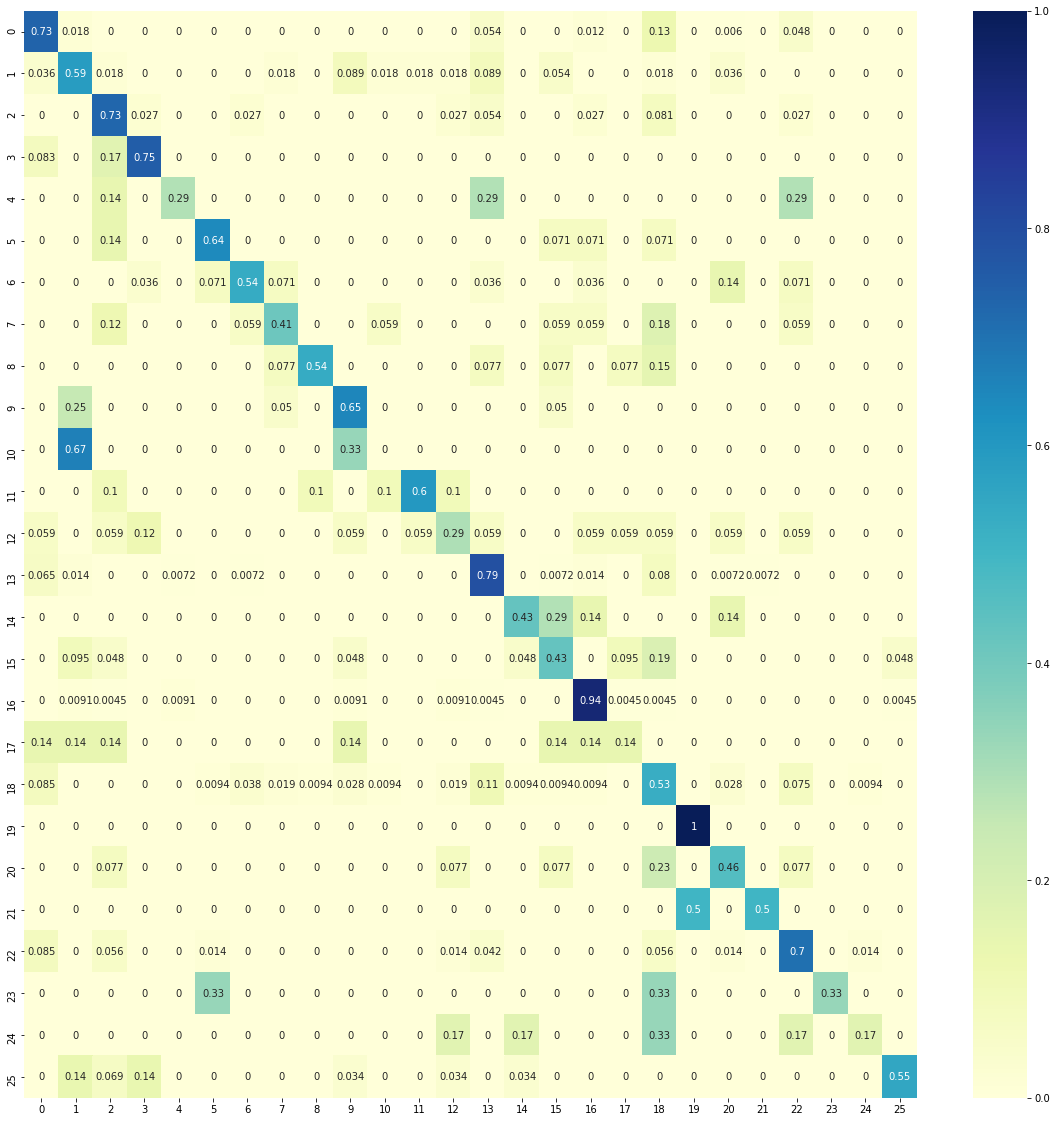

In [145]:
evaluation.plot_confusion_matrix(confusion_matrix)

In [146]:
acc, prec, rec, confusion_matrix = describe(sent_sampler_1, cls, cls.transform2)

In [147]:
acc

(124, 1024, 0.12109375)

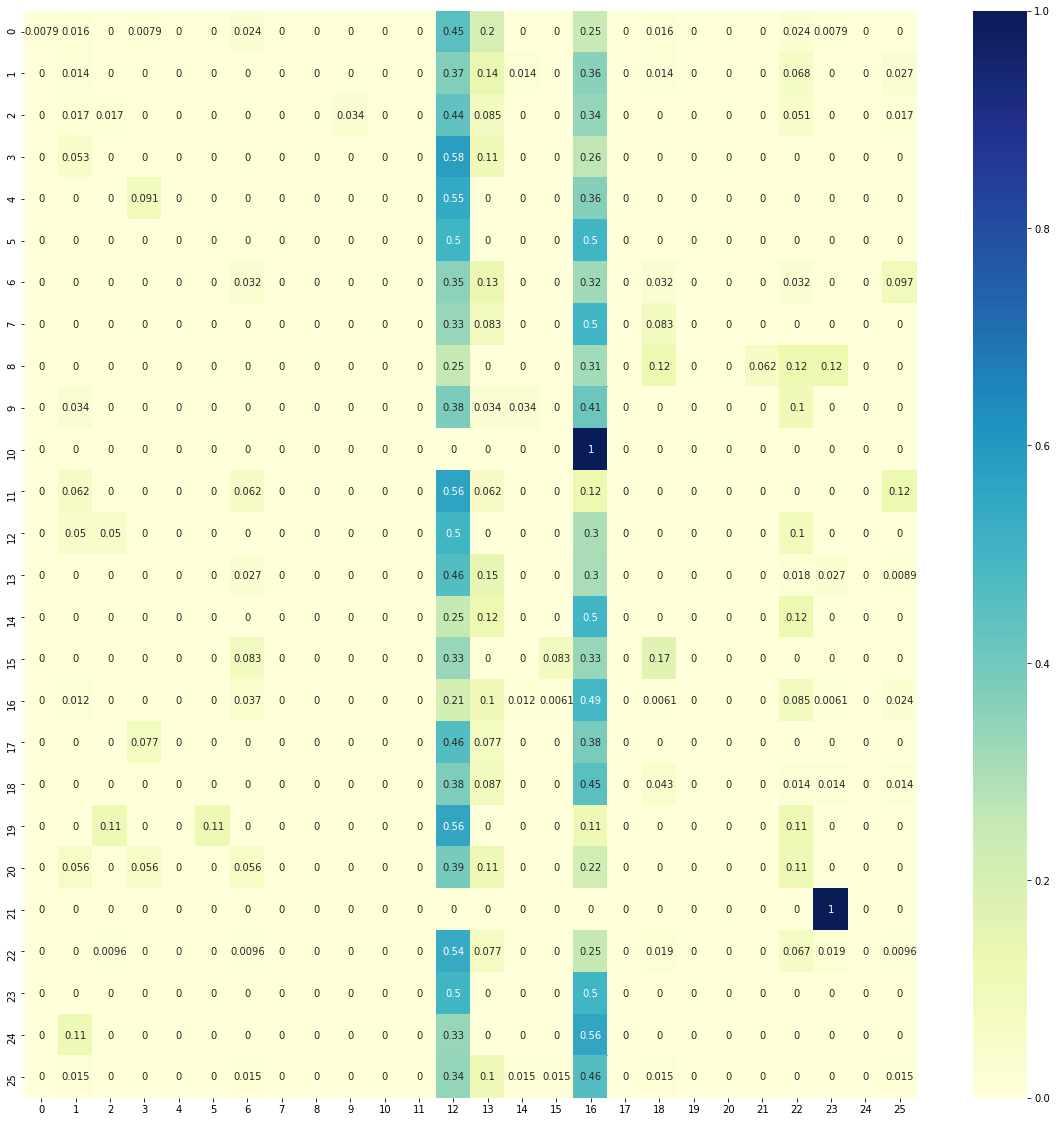

In [148]:
evaluation.plot_confusion_matrix(confusion_matrix)

In [40]:
acc, prec, rec, confusion_matrix = describe(sent_sampler_2, cls, model.IdentityTransformation())

In [41]:
acc

(88, 1024, 0.0859375)

In [42]:
f = """
aider
famille
groupe
regarder
posséder
président
haut
homme
venir
octobre
gros
chaque
chose
femme
trouver
publique
campagne
eau
gauche
bien
pays
jamais
"""
f = [w.strip() for w in f.split("\n") if len(w) > 1]

In [43]:
s ="""
ayudar
familia
grupo
mira
poseer
presidente
alto
hombre
venir
octubre
grande
cada
cosa
mujer
encontrar
público
campaña
agua
izquierda
bueno
país
nunca
"""

f = [w.strip() for w in s.split("\n") if len(w) > 1]


s = """
help
family
group
look
own
president
high
man
come
october
big
every
thing
woman
find
public
campaign
water
left
good
country
never
"""
s = [w.strip() for w in s.split("\n") if len(w) > 1]

In [44]:
s, f = f, s

In [45]:
# def plot_word_by_id(t1, t2, e, f, ids, dims):
#     plt.figure(figsize=(20, 20))
# #     plt.scatter(t1[ids, 0], t1[ids, 1], color='r')
# #     plt.scatter(t2[ids, 0], t2[ids, 1], color='b')
#     plt.xlim(-3, 3)
#     plt.ylim(-3, 3)
#     for id in ids:
#         plt.annotate(e[id], (t1[id, dims[0]], t1[id, dims[1]]), color='r', fontsize=15)
#         plt.annotate(f[id], (t2[id, dims[0]], t2[id, dims[1]]), color='b', fontsize=15)
# #     plt.annotate(e)
# #         print(id)
#     plt.show()

In [46]:
def get_point(id, embeds, dims):
    return embeds[id, dims[0]], embeds[id, dims[1]]

def plot_word_by_id(vocab1, vocab2, orig1, orig2, t1, t2, lang_1, lang_2, dims, hide_original=False):
    plt.figure(figsize=(20, 20))
    assert len(lang_1) == len(lang_2)
    ind_1 = vocab1.transform_one(lang_1)
    ind_2 = vocab2.transform_one(lang_2)
    
    orig1 = orig1[ind_1]
    orig2 = orig2[ind_2]
    t1 = t1[ind_1]
    t2 = t2[ind_2]
    
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    for id, (w1, w2) in enumerate(zip(lang_1, lang_2)):
        if not hide_original:
            plt.annotate(w1, get_point(id, orig1, dims), color='black', fontsize=15)
            plt.annotate(w2, get_point(id, orig2, dims), color='grey', fontsize=15)
        plt.annotate(w1, get_point(id, t1, dims), color='r', fontsize=15)
        plt.annotate(w2, get_point(id, t2, dims), color='b', fontsize=15)

        
        
#     plt.annotate(e)
#         print(id)
    plt.show()

In [47]:
# plot_word_by_id(vocab1, vocab2, vocab1.embeddings, vocab2.embeddings, embeds1, embeds2, f, s, dims=[1, 2], hide_original=True)

In [48]:
# plot_word_by_id(vocab1, vocab2, vocab1.embeddings, vocab2.embeddings, embeds1, embeds2, f, s, dims=[12, 49], hide_original=True)

In [49]:
# e = """
# help
# family
# group
# look
# own
# president
# high
# man
# come
# october
# big
# every
# thing
# woman
# find
# public
# campaign
# water
# left
# good
# country
# never
# """
# e = [w.strip() for w in e.split("\n") if len(w) > 1]

In [50]:
# f = """
# aider
# famille
# groupe
# regarder
# posséder
# président
# haut
# homme
# venir
# octobre
# gros
# chaque
# chose
# femme
# trouver
# publique
# campagne
# eau
# gauche
# bien
# pays
# jamais
# """
# f = [w.strip() for w in f.split("\n") if len(w) > 1]

In [51]:
# cls = cls.cpu()
from sklearn.decomposition import PCA

In [52]:
def get_point_pca(id, embeds):
    return embeds[id, 0], embeds[id, 1]

def plot_words_pca(pca, vocab1, vocab2, orig1, orig2, t1, t2, lang_1, lang_2, hide_original=False):
    plt.figure(figsize=(20, 20))
    assert len(lang_1) == len(lang_2)
    ind_1 = vocab1.transform_one(lang_1)
    ind_2 = vocab2.transform_one(lang_2)
    
    orig1 = pca.transform(orig1[ind_1])
    orig2 = pca.transform(orig2[ind_2])
    t1 = pca.transform(t1[ind_1])
    t2 = pca.transform(t2[ind_2])
    
    plt.xlim(-7, 7)
    plt.ylim(-7, 7)
    for id, (w1, w2) in enumerate(zip(lang_1, lang_2)):
        
        if not hide_original:
            plt.annotate(w1, get_point_pca(id, orig1), color='black', fontsize=15)
            plt.annotate(w2, get_point_pca(id, orig2), color='grey', fontsize=15)
        plt.annotate(w1, get_point_pca(id, t1), color='r', fontsize=15)
        plt.annotate(w2, get_point_pca(id, t2), color='b', fontsize=15)
        
        
#     plt.annotate(e)
#         print(id)
    plt.show()

In [53]:
# pca1 = PCA(n_components=2)
# pca1.fit(vocab1.embeddings)

In [54]:
# pca2 = PCA(n_components=2)
# pca2.fit(vocab2.embeddings)

In [55]:
# pca3 = PCA(n_components=2)
# pca3.fit(embeds1)

In [56]:
# pca4 = PCA(n_components=2)
# pca4.fit(embeds2)

In [57]:
pca = PCA(n_components=2)
# pca.fit(np.vstack([embeds1, embeds2]))
pca.fit(np.vstack([embeds2]))

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

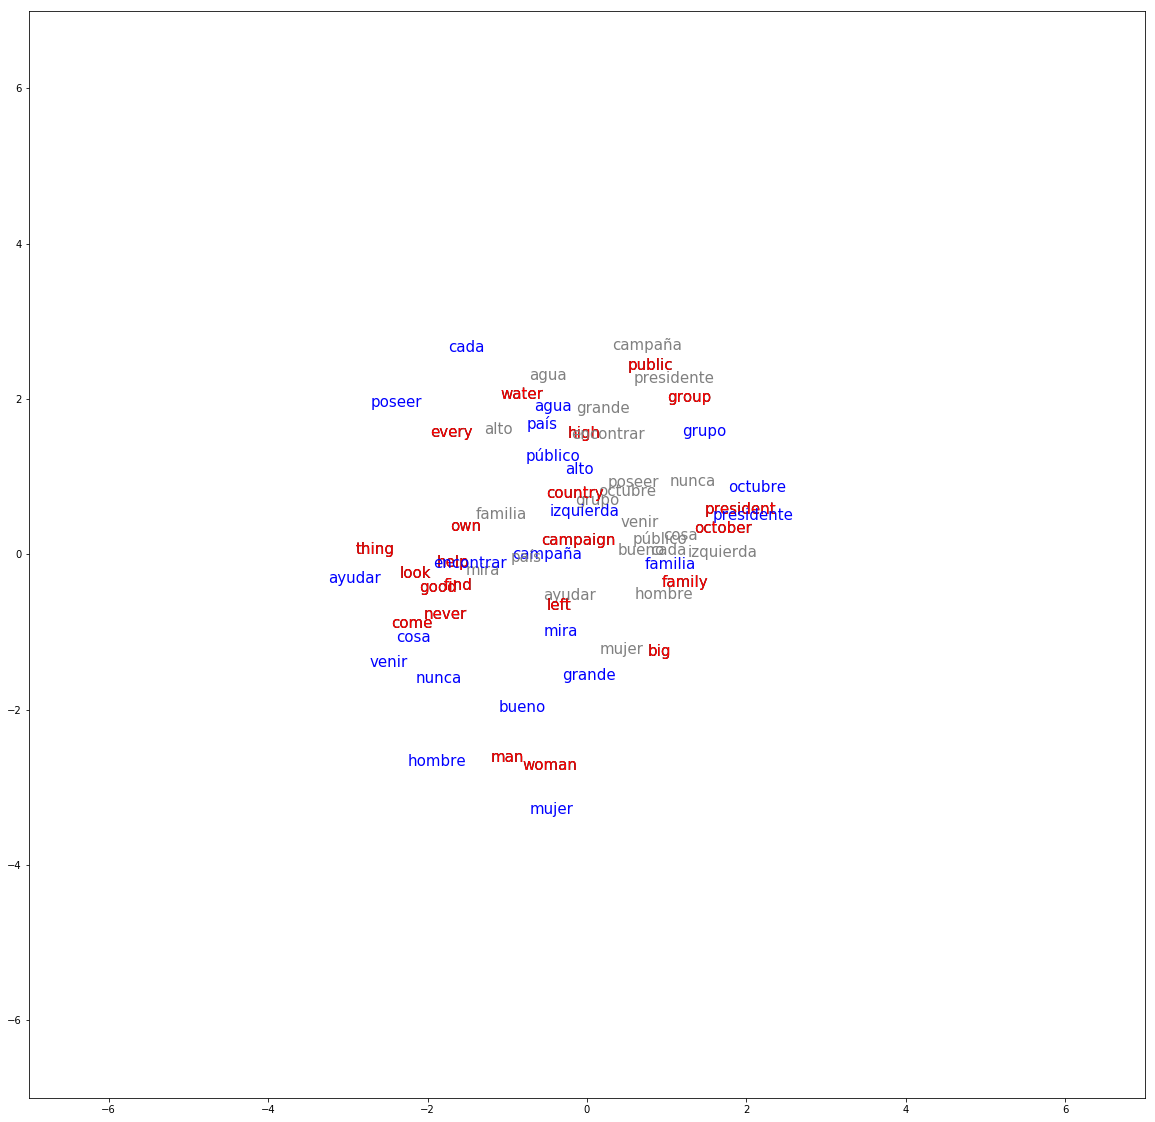

In [58]:
plot_words_pca(pca, vocab1, vocab2, vocab1.embeddings, vocab2.embeddings, embeds1, embeds2, f, s, hide_original=False)

In [59]:
from sklearn.metrics.pairwise import cosine_similarity

In [60]:
import seaborn as sns

In [61]:
# f

In [62]:
def cos(a, b):
    a = a/(a**2).sum(axis=1, keepdims=True)**0.5
    b = b/(b**2).sum(axis=1, keepdims=True)**0.5
    
    return (a * b).sum(axis=1)

def cosine_metrics(vocab1, vocab2, orig1, orig2, t1, t2, lang_1, lang_2):
    assert len(lang_1) == len(lang_2)
    ind_1 = vocab1.transform_one(lang_1)[:-1]
    ind_2 = vocab2.transform_one(lang_2)[:-1]
    
    orig1 = orig1[ind_1]
    orig2 = orig2[ind_2]
    t1 = t1[ind_1]
    t2 = t2[ind_2]
    
    before = cos(orig1, orig2)
    after = cos(t1, t2)
    
    print("{}|{}|{}|{}".format("lang1", "lang2", "before", "after", fill=' ', align='<', width=10))
    for w1, w2, c1, c2 in zip(lang_1, lang_2, before, after):
        print("{}|{}|{:.4f}|{:.4f}".format(w1, w2, c1, c2, fill=' ', align='<', width=10))
    
    c1 = cosine_similarity(orig1, orig2)
    c2 = cosine_similarity(t1, t2)
    plt.figure(figsize=(15, 15))
    sns.heatmap(c1, vmin=-1.0, vmax=1.0, square=True)
    plt.show()
    plt.figure(figsize=(15, 15))
    sns.heatmap(c2, vmin=-1.0, vmax=1.0, square=True)
    plt.show()
    
    plt.figure(figsize=(15, 15))
    sns.heatmap(c2 - c1)
    plt.show()
    
#     print(t1.shape, t2.shape)
#     print(c2.shape)
    s = 0
    for id, w1 in enumerate(lang_1):
#         print(c2[id].argmax())
        translation = lang_2[c2[id].argmax()]
        if translation == lang_2[id]:
            res = "OK"
        else:
            res = "Fail"
        s += translation == lang_2[id]
        print("{} --> {} ({})".format(w1, translation, res))
        
    print(s/len(lang_1))
#     plt.figure(figsize=(15, 15))
#     sns.heatmap((c2 - c1 > 0.1).astype(np.float32))
#     plt.show()
#     print(np.diag(c2))
#     print(np.diag(c1))
#     print()


In [63]:

def word_translation_cosine(vocab1, vocab2, orig1, orig2, t1, t2, lang_1, lang_2):
    assert len(lang_1) == len(lang_2)
    ind_1 = vocab1.transform_one(lang_1)[:-1]
    ind_2 = vocab2.transform_one(lang_2)[:-1]
    
    orig1 = orig1[ind_1]
    orig2 = orig2[ind_2]
    t1 = t1[ind_1]
    t2 = t2[ind_2]
    
    c1 = cosine_similarity(orig1, orig2)
    c2 = cosine_similarity(t1, t2)
    
    count = 0
    for id, w1 in enumerate(lang_1):
        translation = lang_2[c2[id].argmax()]
        if translation == lang_2[id]:
            res = "OK"
        else:
            res = "Fail"
        count += translation == lang_2[id]
        print("{} --> {} ({})".format(w1, translation, res))
        
    print(count/len(lang_1))
    
    count = 0
    for id, w2 in enumerate(lang_2):
        translation = lang_1[c2[:, id].argmax()]
        if translation == lang_1[id]:
            res = "OK"
        else:
            res = "Fail"
        count += translation == lang_1[id]
        print("{} --> {} ({})".format(w2, translation, res))
        
    print(count/len(lang_2))



In [64]:
word_translation_cosine(vocab1, vocab2, vocab1.embeddings, vocab2.embeddings, embeds1, embeds2, f, s)

help --> ayudar (OK)
family --> familia (OK)
group --> grupo (OK)
look --> bueno (Fail)
own --> poseer (OK)
president --> presidente (OK)
high --> alto (OK)
man --> hombre (OK)
come --> venir (OK)
october --> octubre (OK)
big --> grande (OK)
every --> cada (OK)
thing --> cosa (OK)
woman --> mujer (OK)
find --> encontrar (OK)
public --> público (OK)
campaign --> campaña (OK)
water --> agua (OK)
left --> izquierda (OK)
good --> bueno (OK)
country --> país (OK)
never --> nunca (OK)
0.9545454545454546
ayudar --> help (OK)
familia --> family (OK)
grupo --> group (OK)
mira --> look (OK)
poseer --> own (OK)
presidente --> president (OK)
alto --> high (OK)
hombre --> man (OK)
venir --> come (OK)
octubre --> october (OK)
grande --> big (OK)
cada --> every (OK)
cosa --> thing (OK)
mujer --> woman (OK)
encontrar --> find (OK)
público --> public (OK)
campaña --> campaign (OK)
agua --> water (OK)
izquierda --> left (OK)
bueno --> good (OK)
país --> country (OK)
nunca --> never (OK)
1.0


lang1|lang2|before|after
help|ayudar|0.0591|0.5597
family|familia|0.0183|0.4075
group|grupo|0.0535|0.4213
look|mira|0.0569|0.2576
own|poseer|0.0475|0.2819
president|presidente|-0.0324|0.5221
high|alto|0.0782|0.2755
man|hombre|-0.0778|0.4558
come|venir|0.0181|0.3247
october|octubre|0.0116|0.3396
big|grande|-0.0128|0.1718
every|cada|0.0074|0.3367
thing|cosa|-0.0033|0.3755
woman|mujer|0.1033|0.5587
find|encontrar|0.0524|0.4587
public|público|0.0790|0.3497
campaign|campaña|0.0652|0.5762
water|agua|0.0500|0.5680
left|izquierda|0.0386|0.2568
good|bueno|-0.0258|0.4452
country|país|0.0190|0.3299
never|nunca|-0.0212|0.5070


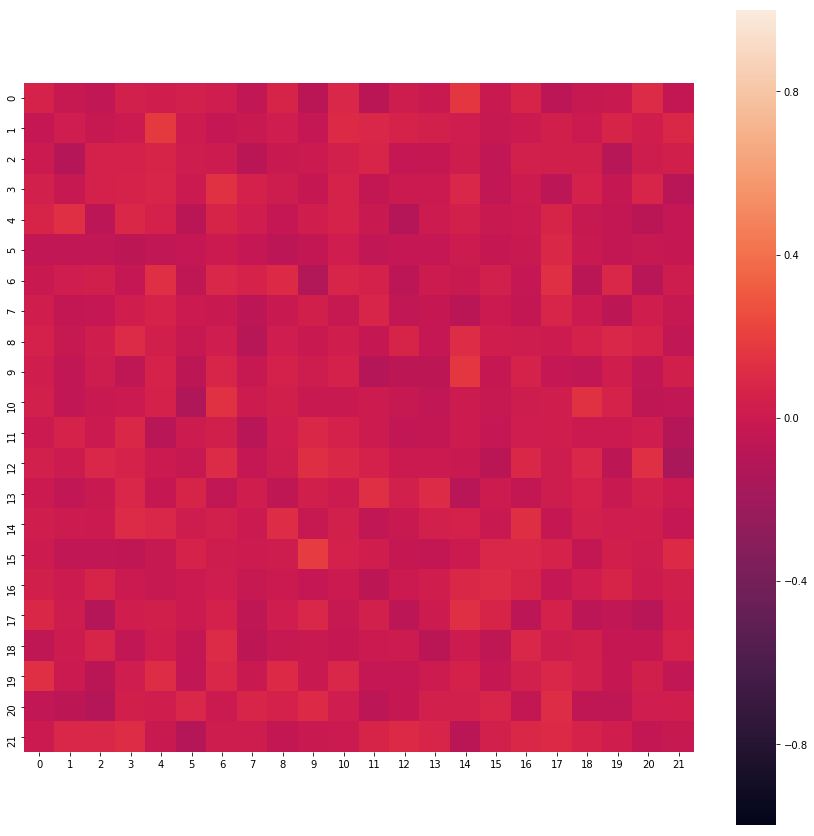

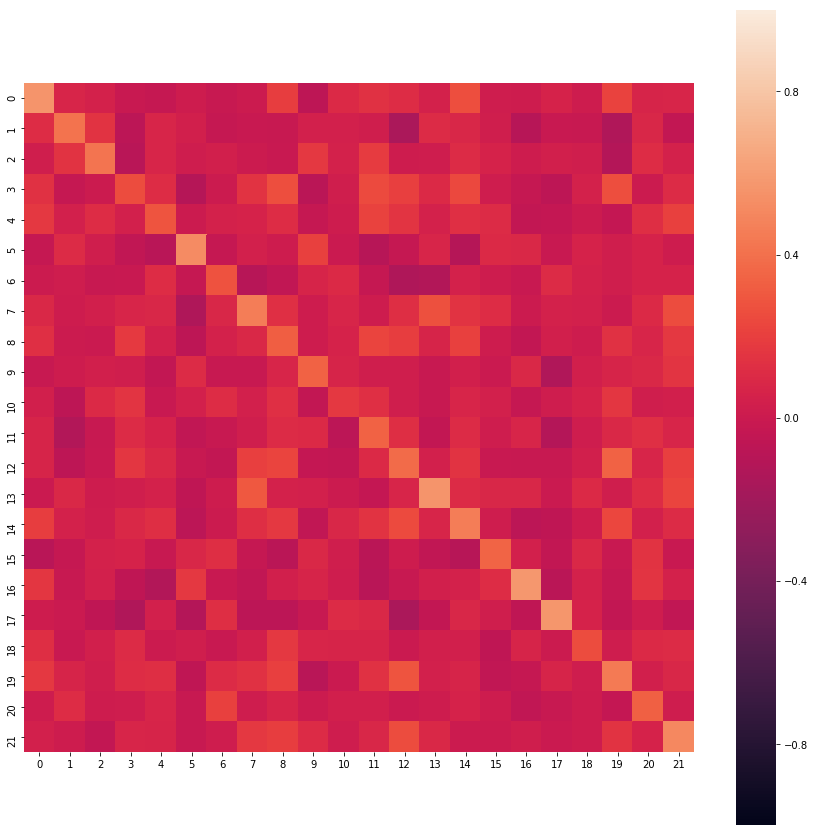

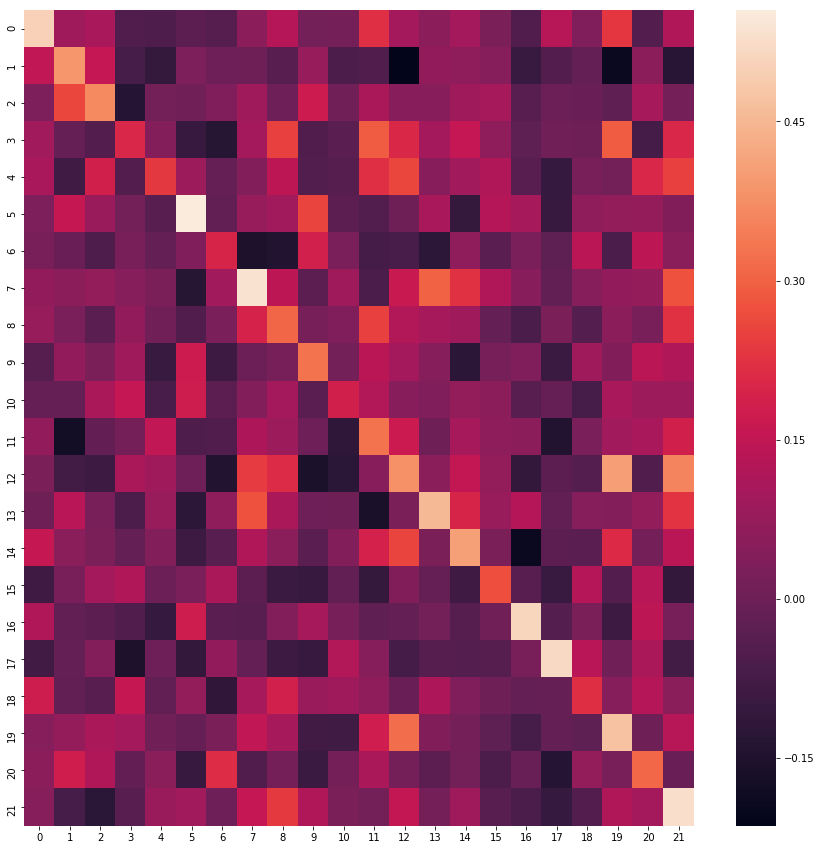

help --> ayudar (OK)
family --> familia (OK)
group --> grupo (OK)
look --> bueno (Fail)
own --> poseer (OK)
president --> presidente (OK)
high --> alto (OK)
man --> hombre (OK)
come --> venir (OK)
october --> octubre (OK)
big --> grande (OK)
every --> cada (OK)
thing --> cosa (OK)
woman --> mujer (OK)
find --> encontrar (OK)
public --> público (OK)
campaign --> campaña (OK)
water --> agua (OK)
left --> izquierda (OK)
good --> bueno (OK)
country --> país (OK)
never --> nunca (OK)
0.9545454545454546


In [65]:
cosine_metrics(vocab1, vocab2, vocab1.embeddings, vocab2.embeddings, embeds1, embeds2, f, s)

In [66]:
# vocab1.transformation

In [67]:
import os
def read_facebook_dict(path, file_name, vocab1, vocab2):
    path = os.path.join(path, file_name)
    
    lang_1 = []
    lang_2 = []
    with open(path, "r") as f:
        for line in f:
            a, b = line.strip().split(" ")
            if a in vocab1.transformation and b in vocab2.transformation:
                lang_1.append(a)
                lang_2.append(b)
                
    return lang_1, lang_2

In [68]:
def word_translation_cosine_silent(vocab1, vocab2, orig1, orig2, t1, t2, lang_1, lang_2,ks,  use_transformed=True,):
    assert len(lang_1) == len(lang_2)
    ind_1 = vocab1.transform_one(lang_1)[:-1]
    ind_2 = vocab2.transform_one(lang_2)[:-1]
    
    orig1 = orig1[ind_1]
    orig2 = orig2[ind_2]
    t1 = t1[ind_1]
    t2 = t2[ind_2]
    
    if use_transformed:
        similarity = cosine_similarity(t1, t2)
    else:
        similarity = cosine_similarity(orig1, orig2)
        
    
    counts1 = {k:0 for k in ks}
    for id, w1 in enumerate(lang_1):
        candidate_ids = (-similarity[id]).argsort()
        for k in ks:
            if id in candidate_ids[:k]:
                counts1[k] += 1
        
    counts2 = {k:0 for k in ks}
    for id, w2 in enumerate(lang_2):
        candidate_ids = (-similarity[:, id]).argsort()
        for k in ks:
            if id in candidate_ids[:k]:
                counts2[k] += 1
        
#     res_for_lang_2 = count/len(lang_2)
    
#     return res_for_lang_1, res_for_lang_2
    for k in ks:
        counts1[k] /= len(lang_1)
        counts2[k] /= len(lang_2)
        
    return counts1, counts2


In [69]:
word_translation_cosine_silent(vocab1, vocab2, vocab1.embeddings, vocab2.embeddings, embeds1, embeds2, f, s, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 50, 100, 200, 500,1000, 2000])

({1: 0.9545454545454546,
  2: 0.9545454545454546,
  3: 1.0,
  4: 1.0,
  5: 1.0,
  6: 1.0,
  7: 1.0,
  8: 1.0,
  9: 1.0,
  10: 1.0,
  50: 1.0,
  100: 1.0,
  200: 1.0,
  500: 1.0,
  1000: 1.0,
  2000: 1.0},
 {1: 1.0,
  2: 1.0,
  3: 1.0,
  4: 1.0,
  5: 1.0,
  6: 1.0,
  7: 1.0,
  8: 1.0,
  9: 1.0,
  10: 1.0,
  50: 1.0,
  100: 1.0,
  200: 1.0,
  500: 1.0,
  1000: 1.0,
  2000: 1.0})

In [70]:
lang_1, lang_2 = read_facebook_dict("../crosslingual/dictionaries/", "en-es.5000-6500.txt", vocab1, vocab2)

In [71]:
# word_translation_cosine_silent(vocab1, vocab2, vocab1.embeddings, vocab2.embeddings, embeds1, embeds2, lang_1, lang_2, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 50, 100, 200, 500,1000, 2000])

In [72]:
def word_translation_cosine_complete(vocab1, vocab2, orig1, orig2, t1, t2, lang_1, lang_2,ks,  use_transformed=True,):
    assert len(lang_1) == len(lang_2)
    ind_1 = vocab1.transform_one(lang_1)[:-1]
    ind_2 = vocab2.transform_one(lang_2)[:-1]
    orig1_complete = orig1
    orig2_complete = orig2
    t1_complete = t1
    t2_complete = t2
    
    orig1 = orig1[ind_1]
    orig2 = orig2[ind_2]
    t1 = t1[ind_1]
    t2 = t2[ind_2]
    
    if use_transformed:
        similarity_1_2 = cosine_similarity(t1, t2_complete)
        similarity_2_1 = cosine_similarity(t2, t1_complete)
    else:
        similarity_1_2 = cosine_similarity(orig1, orig2_complete)
        similarity_2_1 = cosine_similarity(orig2, orig1_complete)
        
    
    counts1 = {k:0 for k in ks}
    for id, w1 in enumerate(lang_1):
        translation_id = vocab2.words.index(lang_2[id])
        candidate_ids = (-similarity_1_2[id]).argsort()
        for k in ks:
            if translation_id in candidate_ids[:k]:
                counts1[k] += 1
        
    counts2 = {k:0 for k in ks}
    for id, w2 in enumerate(lang_2):
        translation_id = vocab1.words.index(lang_1[id])
        candidate_ids = (-similarity_2_1[id]).argsort()
        for k in ks:
            if translation_id in candidate_ids[:k]:
                counts2[k] += 1
        
#     res_for_lang_2 = count/len(lang_2)
    
#     return res_for_lang_1, res_for_lang_2
    for k in ks:
        counts1[k] /= len(lang_1)
        counts2[k] /= len(lang_2)
        
    return counts1, counts2


In [73]:
word_translation_cosine_complete(vocab1, vocab2, vocab1.embeddings, vocab2.embeddings, embeds1, embeds2, lang_1, lang_2, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000], use_transformed=False)

({1: 0.0,
  2: 0.0,
  3: 0.0,
  4: 0.0,
  5: 0.0,
  6: 0.0,
  7: 0.0,
  8: 0.0,
  9: 0.0003667033370003667,
  10: 0.0003667033370003667,
  50: 0.0007334066740007334,
  100: 0.0014668133480014668,
  200: 0.003667033370003667,
  500: 0.011001100110011002,
  1000: 0.019801980198019802,
  2000: 0.03667033370003667,
  5000: 0.09790979097909791,
  10000: 0.20095342867620095,
  20000: 0.40337367070040336,
  50000: 1.0},
 {1: 0.0,
  2: 0.0,
  3: 0.0,
  4: 0.0,
  5: 0.0,
  6: 0.0,
  7: 0.0,
  8: 0.0,
  9: 0.0,
  10: 0.0,
  50: 0.0014668133480014668,
  100: 0.0018335166850018336,
  200: 0.003667033370003667,
  500: 0.010634396773010634,
  1000: 0.02016868353502017,
  2000: 0.03593692702603594,
  5000: 0.09424275760909424,
  10000: 0.20205353868720205,
  20000: 0.39897323065639895,
  50000: 1.0})

In [74]:
word_translation_cosine_complete(vocab1, vocab2, vocab1.embeddings, vocab2.embeddings, embeds1, embeds2, lang_1, lang_2, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000], use_transformed=True)

({1: 0.29262926292629265,
  2: 0.4235423542354235,
  3: 0.491015768243491,
  4: 0.5419875320865419,
  5: 0.5705903923725706,
  6: 0.5951595159515951,
  7: 0.6160616061606161,
  8: 0.6303630363036303,
  9: 0.6431976530986432,
  10: 0.6545654565456546,
  50: 0.7939127246057939,
  100: 0.8448844884488449,
  200: 0.8811881188118812,
  500: 0.92005867253392,
  1000: 0.9486615328199487,
  2000: 0.9655298863219656,
  5000: 0.9853318665199853,
  10000: 0.9926659332599926,
  20000: 0.9974330766409975,
  50000: 1.0},
 {1: 0.3689035570223689,
  2: 0.47231389805647234,
  3: 0.5262192885955262,
  4: 0.5702236890355702,
  5: 0.6039603960396039,
  6: 0.6255958929226256,
  7: 0.6453978731206454,
  8: 0.6574990832416575,
  9: 0.667033370003667,
  10: 0.678034470113678,
  50: 0.8049138247158049,
  100: 0.8467180051338468,
  200: 0.8826549321598827,
  500: 0.9251925192519251,
  1000: 0.9508617528419508,
  2000: 0.9662632929959662,
  5000: 0.9860652731939861,
  10000: 0.9937660432709937,
  20000: 0.997799